# Adversarial Search: Playing "Mean" Connect 4


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it in any column. All disks above the removed disk will fall down one position. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

In [1]:
import numpy as np

# Định nghĩa các hằng số
ROWS = 6
COLS = 7
PLAYER_MAX = 1  # Người chơi 1 (Max)
PLAYER_MIN = -1 # Người chơi 2 (Min)

class MeanConnect4Game:
    """
    Đại diện cho trò chơi 'Mean' Connect 4, định nghĩa theo khuôn khổ Bài toán Tìm kiếm.
    """

    def __init__(self):
        """
        1. Trạng thái Ban đầu (Initial State)
        Khởi tạo bàn cờ và người chơi hiện tại.
        """
        self.board = np.zeros((ROWS, COLS), dtype=int)
        self.current_player = PLAYER_MAX

    def get_initial_state(self):
        """
        Trả về trạng thái ban đầu của trò chơi (board trống và Max đi trước).
        """
        return np.zeros((ROWS, COLS), dtype=int), PLAYER_MAX

    def is_valid_column_for_drop(self, board, col):
        """
        Kiểm tra xem một cột có hợp lệ để thả đĩa hay không (cột chưa đầy).
        """
        # Cột hợp lệ nếu nằm trong phạm vi và hàng trên cùng (hàng 0) còn trống
        return 0 <= col < COLS and board[0, col] == 0

    def get_lowest_empty_row(self, board, col):
        """
        Tìm hàng trống thấp nhất trong một cột. Trả về -1 nếu cột đầy.
        """
        for r in range(ROWS - 1, -1, -1):
            if board[r, col] == 0:
                return r
        return -1

    def get_actions(self, board, player):
        """
        2. Hành động (Actions)
        Trả về danh sách các hành động hợp lệ (Drop và Mean).
        Hành động: ('DROP', col) hoặc ('MEAN', col_remove, col_drop)
        """
        actions = []

        # 1. Hành động Thả đĩa (Drop Disc):
        for c in range(COLS):
            if self.is_valid_column_for_drop(board, c):
                actions.append(('DROP', c))

        # 2. Hành động "Khó tính" (Mean Action):
        # Người chơi hiện tại di chuyển đĩa của đối thủ.
        opponent = -player
        row_bottom = ROWS - 1

        for c_remove in range(COLS):
            # Tìm đĩa đối thủ ở hàng dưới cùng
            if board[row_bottom, c_remove] == opponent:
                # Có thể đặt lại vào bất kỳ cột nào
                for c_drop in range(COLS):
                    # Hành động khó tính hợp lệ nếu cột đặt lại CHƯA đầy
                    if self.is_valid_column_for_drop(board, c_drop):
                        # Ghi chú: Hành động 'MEAN' luôn di chuyển đĩa đối thủ
                        actions.append(('MEAN', c_remove, c_drop))

        return actions

    def result(self, board, action, player):
        """
        3. Mô hình Chuyển đổi (Transition Model)
        Trả về trạng thái bàn cờ mới sau khi thực hiện hành động.
        """
        new_board = np.copy(board)

        if action[0] == 'DROP':
            # Hành động Thả đĩa
            _, c = action
            r = self.get_lowest_empty_row(new_board, c)
            if r != -1:
                new_board[r, c] = player

        elif action[0] == 'MEAN':
            # Hành động "Khó tính"
            _, c_remove, c_drop = action
            row_bottom = ROWS - 1
            opponent = -player

            # 1. Loại bỏ đĩa đối thủ ở hàng dưới cùng
            # Hành động này chỉ được gọi nếu đĩa đối thủ (-player) tồn tại ở đây
            # new_board[row_bottom, c_remove] = opponent # (Chỉ để kiểm tra)

            # 1a. Loại bỏ đĩa
            new_board[row_bottom, c_remove] = 0

            # 2. Các đĩa phía trên trong cột c_remove rơi xuống
            # Dịch chuyển các đĩa từ hàng 0 đến hàng (row_bottom - 1) xuống một hàng
            for r in range(row_bottom - 1, -1, -1):
                new_board[r + 1, c_remove] = new_board[r, c_remove]
            new_board[0, c_remove] = 0 # Ô trên cùng (r=0) trở nên trống

            # 3. Đặt lại đĩa đối thủ vào c_drop
            r_drop = self.get_lowest_empty_row(new_board, c_drop)
            if r_drop != -1:
                new_board[r_drop, c_drop] = opponent # Đặt đĩa đối thủ (-player)

        return new_board, -player # Trạng thái mới và đổi lượt chơi

    def check_win(self, board, player):
        """
        Hàm hỗ trợ: Kiểm tra xem người chơi đã thắng hay chưa (4 đĩa thẳng hàng).
        Kiểm tra 4 chiều: Ngang, Dọc, Chéo xuôi, Chéo ngược.
        """
        # 1. Kiểm tra Ngang (Horizontal)
        for r in range(ROWS):
            for c in range(COLS - 3):
                if np.all(board[r, c:c+4] == player):
                    return True

        # 2. Kiểm tra Dọc (Vertical)
        for c in range(COLS):
            for r in range(ROWS - 3):
                if np.all(board[r:r+4, c] == player):
                    return True

        # 3. Kiểm tra Chéo Xuôi (Diagonal Down-Right)
        for r in range(ROWS - 3):
            for c in range(COLS - 3):
                if board[r, c] == player and \
                   board[r+1, c+1] == player and \
                   board[r+2, c+2] == player and \
                   board[r+3, c+3] == player:
                    return True

        # 4. Kiểm tra Chéo Ngược (Diagonal Up-Right)
        for r in range(3, ROWS): # Bắt đầu từ hàng 3 (từ dưới lên)
            for c in range(COLS - 3):
                if board[r, c] == player and \
                   board[r-1, c+1] == player and \
                   board[r-2, c+2] == player and \
                   board[r-3, c+3] == player:
                    return True

        return False

    def is_terminal(self, board):
        """
        4. Kiểm tra Trạng thái Kết thúc (Terminal State Test)
        """
        # Kiểm tra Thắng/Thua (Connect 4)
        if self.check_win(board, PLAYER_MAX) or self.check_win(board, PLAYER_MIN):
            return True

        # Kiểm tra Hòa (Bàn cờ đầy)
        # Bàn cờ đầy nếu không còn ô trống (giá trị 0)
        if 0 not in board:
            return True

        return False

    def utility(self, board):
        """
        5. Tiện ích cho Trạng thái Kết thúc (Utility)
        Trả về tiện ích từ góc nhìn của PLAYER_MAX (1).
        """
        if self.check_win(board, PLAYER_MAX):
            return 1   # Max thắng
        if self.check_win(board, PLAYER_MIN):
            return -1  # Min thắng

        # Bàn cờ đầy (hòa)
        return 0

How big is the state space? Give an estimate and explain it.

# Your code/ answer goes here.
Cell này yêu cầu ước tính và giải thích về kích thước không gian trạng thái (state space) của trò chơi "Mean" Connect 4 (6×7).

Kích thước Không gian Trạng thái (State Space Size)
Kích thước không gian trạng thái của trò chơi "Mean" Connect 4 là lớn hơn đáng kể so với Connect 4 truyền thống.

Trò chơi	Kích thước Ước tính (Trạng thái)	Giải thích
Connect 4 Truyền thống	≈4.5×10
12
 	Chỉ có thể thả đĩa (tính chất đơn điệu), số lượng đĩa luôn tăng.
"Mean" Connect 4	≫4.5×10
12
  (Lớn hơn rất nhiều)	Hành động "Mean" phá vỡ tính đơn điệu, cho phép di chuyển và hoán đổi vị trí các quân cờ đã đặt, dẫn đến nhiều cấu hình cờ hơn cho cùng một số lượng quân cờ.

Xuất sang Trang tính

Giải thích Chi tiết
Connect 4 Truyền thống (Cận dưới):

Connect 4 truyền thống có tổng cộng 6×7=42 ô.

Mỗi ô có 3 trạng thái: Trống (0), Người chơi 1 (1), Người chơi 2 (-1).

Tổng số cấu hình có thể là 3
42
 ≈1.2×10
20
 .

Tuy nhiên, Connect 4 có luật chơi hạn chế: đĩa luôn rơi xuống vị trí thấp nhất (tính chất đơn điệu). Điều này làm giảm đáng kể không gian trạng thái thực tế xuống khoảng 4.5×10
12
  trạng thái hợp lệ.

"Mean" Connect 4 (Tăng trưởng Không gian):

Hành động "Mean" (Khó tính) cho phép người chơi lấy đĩa của đối thủ từ hàng dưới cùng và đặt lại nó vào một cột khác.

Phá vỡ tính đơn điệu: Hành động này làm cho một số lượng đĩa cố định có thể có nhiều cấu hình hợp lệ hơn trên bàn cờ so với Connect 4 truyền thống.

Trong C4 truyền thống, trạng thái cờ được xác định bởi "chiều cao" của đĩa trong mỗi cột.

Trong "Mean" C4, một đĩa ở vị trí thấp hơn có thể di chuyển (thay đổi cột), và các đĩa bên trên nó rơi xuống.

Tạo ra các trạng thái "bất hợp lệ" của C4 truyền thống: Trạng thái của "Mean" Connect 4 không bị giới hạn bởi luật thả đĩa truyền thống. Cùng một số lượng đĩa có thể được sắp xếp theo nhiều cách khác nhau, miễn là chúng không "lơ lửng" (sau khi di chuyển, các đĩa bên trên luôn rơi xuống).

Ước tính: Vì hành động "Mean" giới thiệu thêm tính hoán vị (permutations) của các đĩa đã đặt mà không tuân theo quy tắc thả đĩa nghiêm ngặt, số lượng trạng thái hợp lệ phải vượt xa con số 4.5×10
12
  của trò chơi gốc. Kích thước thực tế sẽ gần hơn với 3
42
  hoặc có thể lớn hơn một trò chơi có tính chất di chuyển quân cờ (như cờ vua).

Mặc dù rất khó để đưa ra con số chính xác, nhưng có thể kết luận rằng không gian trạng thái của "Mean" Connect 4 lớn hơn đáng kể và thách thức hơn để khám phá hoàn toàn.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

Độ Rộng (Branching Factor)Độ rộng của cây trò chơi đại diện cho số lượng hành động hợp lệ từ một trạng thái bất kỳ.Connect 4 Tiêu chuẩn: Độ rộng tối đa là 7 (thả đĩa vào 7 cột)."Mean" Connect 4: Độ rộng tăng lên đáng kể do hành động "Mean" (Khó tính).Hành động Drop: Tối đa 7 hành động.Hành động Mean: Hành động này bao gồm việc chọn một đĩa đối thủ ở hàng dưới cùng ($c_{\text{remove}}$) và đặt lại nó ($c_{\text{drop}}$).Tối đa $C_{\text{remove}} = 7$ lựa chọn đĩa đối thủ (ở hàng dưới cùng).Tối đa $C_{\text{drop}} = 7$ lựa chọn cột để đặt lại đĩa.Số hành động Mean tối đa là $7 \times 7 = \mathbf{49}$ hành động.Độ Rộng Tối đa Ước tính ($\mathbf{b}$): $b \le 7 (\text{Drop}) + 49 (\text{Mean}) = \mathbf{56}$ nước đi.Kết luận: Độ rộng tối đa của "Mean" Connect 4 là khoảng $\mathbf{56}$ nước đi.

Độ Sâu và Tổng Kích thước Cây Trò chơi

Độ sâu tự nhiên: Connect 4 Tiêu chuẩn"Mean" Connect 4 Tối đa $\mathbf{42}$ nước đi, "Mean" Connect 4 Vô hạn (Không bị giới hạn)

Kích thước Cây: Connect 4 Tiêu chuẩn$\approx 10^{14}$ đến $10^{20}$ nút "Mean" Connect 4 Vô hạn (Nếu không cắt tỉa)

Độ Sâu Vô hạn (Vấn đề chính):Trong Connect 4 tiêu chuẩn, mỗi nước đi đều thêm một đĩa, đảm bảo trò chơi kết thúc sau tối đa 42 nước đi.Trong "Mean" Connect 4, hành động "Mean" (di chuyển đĩa đối thủ) không làm tăng tổng số đĩa và có thể ngăn chặn việc bàn cờ bị đầy hoặc hình thành chuỗi chiến thắng.Điều này tạo ra khả năng lặp lại trạng thái (cycles), nơi hai người chơi có thể liên tục di chuyển đĩa và quay lại trạng thái đã đi qua, dẫn đến một cây trò chơi có độ sâu tiềm năng là vô hạn.Hậu quả đối với Minimax:Vì cây trò chơi không tự nhiên kết thúc, thuật toán Minimax cơ bản sẽ không hoạt động trừ khi có một số cơ chế cắt tỉa hoặc giới hạn.Do đó, thay vì tìm kiếm toàn bộ cây trò chơi (vô hạn), Minimax sẽ phải được thực hiện với Giới hạn Độ sâu (Depth Limit).Kích thước Cây Minimax thực tế (Có Giới hạn):Nếu bạn giới hạn độ sâu tìm kiếm là $d$ (ví dụ: $d=8$ như thường thấy trong các bài toán AI), kích thước cây tìm kiếm sẽ là $N \approx b^d$.Với $b \approx 50$ và giới hạn độ sâu $d=8$:$$N \approx 50^8 = \mathbf{390.625 \times 10^{12} \text{ nút}}$$

## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [2]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

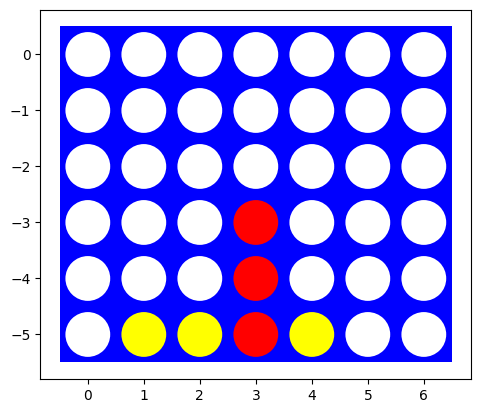

In [3]:
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [4]:
# Your code/ answer goes here.
import numpy as np

# Định nghĩa các hằng số (Có thể thay đổi để kiểm tra kích thước khác)
ROWS = 6
COLS = 7
PLAYER_MAX = 1  # Người chơi 1 (Max)
PLAYER_MIN = -1 # Người chơi 2 (Min)
IN_ROW_TO_WIN = 4 # Số đĩa liên tiếp để thắng

class MeanConnect4Game:
    """
    Triển khai các hàm lõi (Actions, Result, Utility, Terminal) cho trò chơi 'Mean' Connect 4.
    """

    def __init__(self):
        # Lấy kích thước bàn cờ từ hằng số toàn cục
        self.rows = ROWS
        self.cols = COLS
        self.in_row_to_win = IN_ROW_TO_WIN
        self.board = np.zeros((self.rows, self.cols), dtype=int)
        self.current_player = PLAYER_MAX

    # --- HÀM TRỢ GIÚP CHUNG ---

    def get_initial_state(self):
        """Trả về trạng thái ban đầu của trò chơi."""
        return np.zeros((self.rows, self.cols), dtype=int), PLAYER_MAX

    def is_valid_column_for_drop(self, board, col):
        """Kiểm tra cột có hợp lệ để thả đĩa hay không."""
        # Kiểm tra nằm trong phạm vi và hàng trên cùng (hàng 0) còn trống
        return 0 <= col < self.cols and board[0, col] == 0

    def get_lowest_empty_row(self, board, col):
        """Tìm hàng trống thấp nhất trong một cột. Trả về -1 nếu cột đầy."""
        for r in range(self.rows - 1, -1, -1):
            if board[r, col] == 0:
                return r
        return -1

    # --- HÀM LÕI CỦA BÀI TOÁN TÌM KIẾM ---

    def get_actions(self, board, player):
        """
        [actions(s)]: Trả về danh sách các hành động hợp lệ (Drop và Mean).
        Hành động: ('DROP', col) hoặc ('MEAN', col_remove, col_drop)
        """
        actions = []

        # 1. Hành động Thả đĩa (Drop Disc):
        for c in range(self.cols):
            if self.is_valid_column_for_drop(board, c):
                actions.append(('DROP', c))

        # 2. Hành động "Khó tính" (Mean Action):
        opponent = -player
        row_bottom = self.rows - 1

        for c_remove in range(self.cols):
            # Kiểm tra đĩa đối thủ ở hàng dưới cùng
            if board[row_bottom, c_remove] == opponent:
                # Có thể đặt lại vào bất kỳ cột nào
                for c_drop in range(self.cols):
                    # Hành động hợp lệ nếu cột đặt lại CHƯA đầy
                    if self.is_valid_column_for_drop(board, c_drop):
                        actions.append(('MEAN', c_remove, c_drop))

        return actions

    def result(self, board, action, player):
        """
        [result(s, a)]: Mô hình Chuyển đổi. Trả về trạng thái bàn cờ mới.
        """
        new_board = np.copy(board)

        if action[0] == 'DROP':
            # 1. Hành động Thả đĩa: Đặt đĩa người chơi vào vị trí thấp nhất
            _, c = action
            r = self.get_lowest_empty_row(new_board, c)
            if r != -1:
                new_board[r, c] = player

        elif action[0] == 'MEAN':
            # 2. Hành động "Khó tính"
            _, c_remove, c_drop = action
            row_bottom = self.rows - 1
            opponent = -player

            # 2a. Loại bỏ đĩa đối thủ ở hàng dưới cùng
            new_board[row_bottom, c_remove] = 0

            # 2b. Các đĩa phía trên trong cột c_remove rơi xuống
            # Dịch chuyển từ hàng (r-1) xuống hàng r
            for r in range(row_bottom - 1, -1, -1):
                new_board[r + 1, c_remove] = new_board[r, c_remove]
            new_board[0, c_remove] = 0 # Ô trên cùng trở nên trống

            # 2c. Đặt lại đĩa đối thủ vào c_drop
            r_drop = self.get_lowest_empty_row(new_board, c_drop)
            if r_drop != -1:
                new_board[r_drop, c_drop] = opponent

        return new_board, -player # Trạng thái mới và đổi lượt chơi

    def check_win(self, board, player):
        """
        Hàm hỗ trợ: Kiểm tra 4 đĩa thẳng hàng (ngang, dọc, chéo).
        Hàm này linh hoạt theo self.rows, self.cols và self.in_row_to_win.
        """
        K = self.in_row_to_win

        # 1. Kiểm tra Ngang (Horizontal)
        for r in range(self.rows):
            for c in range(self.cols - K + 1):
                if np.all(board[r, c:c+K] == player):
                    return True

        # 2. Kiểm tra Dọc (Vertical)
        for c in range(self.cols):
            for r in range(self.rows - K + 1):
                if np.all(board[r:r+K, c] == player):
                    return True

        # 3. Kiểm tra Chéo Xuôi (Diagonal Down-Right)
        for r in range(self.rows - K + 1):
            for c in range(self.cols - K + 1):
                if all(board[r+i, c+i] == player for i in range(K)):
                    return True

        # 4. Kiểm tra Chéo Ngược (Diagonal Up-Right)
        for r in range(K - 1, self.rows): # Bắt đầu từ hàng K-1 (từ dưới lên)
            for c in range(self.cols - K + 1):
                if all(board[r-i, c+i] == player for i in range(K)):
                    return True

        return False


    def is_terminal(self, board):
        """
        [terminal(s)]: Kiểm tra Trạng thái Kết thúc (Terminal State Test)
        """
        # Kiểm tra Thắng/Thua
        if self.check_win(board, PLAYER_MAX) or self.check_win(board, PLAYER_MIN):
            return True

        # Kiểm tra Hòa (Bàn cờ đầy)
        if 0 not in board:
            return True

        return False

    def utility(self, board):
        """
        [utility(s)]: Tiện ích cho Trạng thái Kết thúc.
        Trả về tiện ích từ góc nhìn của PLAYER_MAX (1).
        """
        if self.check_win(board, PLAYER_MAX):
            return 1   # Max thắng
        if self.check_win(board, PLAYER_MIN):
            return -1  # Min thắng

        # Trạng thái kết thúc còn lại là Hòa (Bàn cờ đầy)
        return 0


Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on bt yhe environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [21]:
# Your code/ answer goes here.
import random
game_logic = MeanConnect4Game()

def random_player(board, player):
    """
    Agent ngẫu nhiên: Chọn một hành động hợp lệ bất kỳ.

    Args:
        board (np.array): Trạng thái bàn cờ hiện tại.
        player (int): Người chơi hiện tại (1 hoặc -1).

    Returns:
        tuple: Hành động được chọn (('DROP', col) hoặc ('MEAN', c_remove, c_drop)).
    """
    # Lấy tất cả các hành động hợp lệ từ trạng thái hiện tại
    actions = game_logic.get_actions(board, player)

    if not actions:
        # Trường hợp hiếm: không có hành động nào hợp lệ (thường là trò chơi đã kết thúc)
        return None

    # Chọn ngẫu nhiên một hành động trong danh sách
    return random.choice(actions)

# --- VÍ DỤ MINH HỌA (Có thể xóa nếu không cần) ---
def display_board(board):
    """Hiển thị bàn cờ một cách dễ đọc."""
    print("-----------------------------")
    for r in range(ROWS):
        row_str = " | ".join(["X" if board[r, c] == PLAYER_MAX else "O" if board[r, c] == PLAYER_MIN else " " for c in range(COLS)])
        print(f"| {row_str} |")
    print("-----------------------------")
    print("  " + "  ".join([f"{c}" for c in range(COLS)])) # Chỉ số cột

if __name__ == '__main__':
    # Ví dụ kiểm tra agent ngẫu nhiên
    game = MeanConnect4Game()
    current_board, current_player = game.get_initial_state()

    print("--- Bắt đầu Trò chơi Ngẫu nhiên ---")

    for i in range(5): # Chơi 5 nước ngẫu nhiên
        if game.is_terminal(current_board):
            break

        print(f"\nLượt: {i+1}. Người chơi {'MAX (X)' if current_player == PLAYER_MAX else 'MIN (O)'}")

        # Agent ngẫu nhiên chọn hành động
        action = random_player(current_board, current_player)
        print(f"Hành động được chọn: {action}")

        if action is None:
            print("Không có hành động hợp lệ. Game kết thúc.")
            break

        # Chuyển đổi trạng thái
        current_board, current_player = game.result(current_board, action, current_player)
        display_board(current_board)

    if game.is_terminal(current_board):
        utility_value = game.utility(current_board)
        print(f"\nGame Kết thúc! Utility (Max): {utility_value}")


--- Bắt đầu Trò chơi Ngẫu nhiên ---

Lượt: 1. Người chơi MAX (X)
Hành động được chọn: ('DROP', 3)
-----------------------------
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | X |   |   |   |
-----------------------------
  0  1  2  3  4  5  6

Lượt: 2. Người chơi MIN (O)
Hành động được chọn: ('DROP', 5)
-----------------------------
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | X |   | O |   |
-----------------------------
  0  1  2  3  4  5  6

Lượt: 3. Người chơi MAX (X)
Hành động được chọn: ('DROP', 3)
-----------------------------
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | X |   |   |   |
|   |   |   | X |   | O |   |
-----------------------------
  0  1  2  3  

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [22]:
# Your code/ answer goes here.
def play_game(game_logic, agent_max, agent_min, verbose=False):
    """
    Mô phỏng một ván đấu duy nhất giữa hai agent.

    Args:
        game_logic (MeanConnect4Game): Đối tượng logic trò chơi.
        agent_max (function): Hàm agent cho người chơi MAX.
        agent_min (function): Hàm agent cho người chơi MIN.
        verbose (bool): In ra các bước nếu True.

    Returns:
        int: Utility của trạng thái cuối cùng (1 cho MAX thắng, -1 cho MIN thắng, 0 cho Hòa).
    """
    board, player = game_logic.get_initial_state()

    # Giới hạn độ sâu để tránh vòng lặp vô hạn (chỉ phòng ngừa)
    move_count = 0
    MAX_MOVES = ROWS * COLS * 2 # 84 nước đi là đủ an toàn

    while not game_logic.is_terminal(board) and move_count < MAX_MOVES:

        # Chọn hành động
        if player == PLAYER_MAX:
            action = agent_max(board, player)
        else: # player == PLAYER_MIN
            action = agent_min(board, player)

        if action is None:
            # Nếu không có hành động nào hợp lệ (ngoại trừ terminal), coi là hòa
            return 0

        # Chuyển đổi trạng thái
        board, player = game_logic.result(board, action, player)
        move_count += 1

    # Kiểm tra trạng thái cuối cùng
    if move_count >= MAX_MOVES and not game_logic.is_terminal(board):
        return 0 # Coi là hòa nếu đạt đến giới hạn nước đi

    return game_logic.utility(board)

def run_experiment(game_logic, agent1, agent2, num_games):
    """
    Chạy một loạt trò chơi giữa Agent 1 và Agent 2, đổi lượt chơi sau mỗi ván.

    Returns:
        dict: Kết quả thắng/thua/hòa.
    """
    results = {'agent1_wins': 0, 'agent2_wins': 0, 'draws': 0}

    # print(f"Bắt đầu chạy {num_games} ván đấu giữa {agent1.__name__} và {agent2.__name__}...")

    for i in range(num_games):
        if i % 2 == 0:
            # Ván chẵn: Agent 1 (MAX) vs Agent 2 (MIN)
            utility = play_game(game_logic, agent1, agent2)
            if utility == PLAYER_MAX:
                results['agent1_wins'] += 1
            elif utility == PLAYER_MIN:
                results['agent2_wins'] += 1
            else:
                results['draws'] += 1
        else:
            # Ván lẻ: Agent 2 (MAX) vs Agent 1 (MIN) - Đổi lượt
            # Người chơi MAX luôn là người đi trước trong mỗi ván
            utility = play_game(game_logic, agent2, agent1)
            # Utility được tính từ góc nhìn của người đi trước (Agent 2 trong ván này)
            if utility == PLAYER_MAX:
                results['agent2_wins'] += 1
            elif utility == PLAYER_MIN:
                results['agent1_wins'] += 1
            else:
                results['draws'] += 1

    return results

if __name__ == '__main__':
    # Chạy thử nghiệm giữa hai agent ngẫu nhiên 1000 lần
    NUM_GAMES = 1000

    experiment_results = run_experiment(game_logic, random_player, random_player, NUM_GAMES)

    print("\n--- KẾT QUẢ THỬ NGHIỆM SAU 1000 VÁN (Random vs Random) ---")
    print(f"Tổng số ván: {NUM_GAMES}")
    print(f"Agent 1 ({random_player.__name__}) thắng: {experiment_results['agent1_wins']} ({experiment_results['agent1_wins']/NUM_GAMES*100:.2f}%)")
    print(f"Agent 2 ({random_player.__name__}) thắng: {experiment_results['agent2_wins']} ({experiment_results['agent2_wins']/NUM_GAMES*100:.2f}%)")
    print(f"Ván hòa: {experiment_results['draws']} ({experiment_results['draws']/NUM_GAMES*100:.2f}%)")


--- KẾT QUẢ THỬ NGHIỆM SAU 1000 VÁN (Random vs Random) ---
Tổng số ván: 1000
Agent 1 (random_player) thắng: 510 (51.00%)
Agent 2 (random_player) thắng: 490 (49.00%)
Ván hòa: 0 (0.00%)


## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting.

Implement the search starting from a given board and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [26]:
import math
import sys
import numpy as np
import random
import time

ROWS = 4
COLS = 4
PLAYER_MAX = 1
PLAYER_MIN = -1
IN_ROW_TO_WIN = 3

DEPTH_LIMIT = 4
INF = sys.maxsize

class MeanConnect4Game:

    def __init__(self):
        self.rows = ROWS
        self.cols = COLS
        self.in_row_to_win = IN_ROW_TO_WIN

    def get_initial_state(self):
        return np.zeros((self.rows, self.cols), dtype=int), PLAYER_MAX

    def is_valid_column_for_drop(self, board, col):
        return 0 <= col < self.cols and board[0, col] == 0

    def get_lowest_empty_row(self, board, col):
        for r in range(self.rows - 1, -1, -1):
            if board[r, col] == 0:
                return r
        return -1

    def get_actions(self, board, player):
        actions = []
        opponent = -player
        row_bottom = self.rows - 1

        for c in range(self.cols):
            if self.is_valid_column_for_drop(board, c):
                actions.append(('DROP', c))

        for c_remove in range(self.cols):
            if board[row_bottom, c_remove] == opponent:
                for c_drop in range(self.cols):
                    if self.is_valid_column_for_drop(board, c_drop):
                        actions.append(('MEAN', c_remove, c_drop))

        return actions

    def result(self, board, action, player):
        new_board = np.copy(board)

        if action[0] == 'DROP':
            _, c = action
            r = self.get_lowest_empty_row(new_board, c)
            if r != -1:
                new_board[r, c] = player

        elif action[0] == 'MEAN':
            _, c_remove, c_drop = action
            row_bottom = self.rows - 1
            opponent = -player

            new_board[row_bottom, c_remove] = 0

            for r in range(row_bottom - 1, -1, -1):
                new_board[r + 1, c_remove] = new_board[r, c_remove]
            new_board[0, c_remove] = 0

            r_drop = self.get_lowest_empty_row(new_board, c_drop)
            if r_drop != -1:
                new_board[r_drop, c_drop] = opponent

        return new_board, -player

    def check_win(self, board, player):
        K = self.in_row_to_win

        for r in range(self.rows):
            for c in range(self.cols - K + 1):
                if np.all(board[r, c:c+K] == player):
                    return True

        for c in range(self.cols):
            for r in range(self.rows - K + 1):
                if np.all(board[r:r+K, c] == player):
                    return True

        for r in range(self.rows - K + 1):
            for c in range(self.cols - K + 1):
                if all(board[r+i, c+i] == player for i in range(K)):
                    return True

        for r in range(K - 1, self.rows):
            for c in range(self.cols - K + 1):
                if all(board[r-i, c+i] == player for i in range(K)):
                    return True

        return False


    def is_terminal(self, board):
        if self.check_win(board, PLAYER_MAX) or self.check_win(board, PLAYER_MIN):
            return True

        if 0 not in board:
            return True

        return False

    def utility(self, board):
        if self.check_win(board, PLAYER_MAX):
            return 1
        if self.check_win(board, PLAYER_MIN):
            return -1

        return 0

game_logic = MeanConnect4Game()

def random_player(board, player):
    actions = game_logic.get_actions(board, player)
    if not actions:
        return None
    return random.choice(actions)

def evaluation_function(board):
    score = 0
    K = game_logic.in_row_to_win

    weights = {2: 5, 3: 50}

    def count_scores(board, player):
        player_score = 0

        directions = [
            (0, 1),
            (1, 0),
            (1, 1),
            (1, -1)
        ]

        for r_start in range(game_logic.rows):
            for c_start in range(game_logic.cols):
                for dr, dc in directions:
                    if 0 <= r_start + (K-1)*dr < game_logic.rows and \
                       0 <= c_start + (K-1)*dc < game_logic.cols:

                        window = []
                        for i in range(K):
                            window.append(board[r_start + i*dr, c_start + i*dc])

                        window = np.array(window)
                        p_count = np.sum(window == player)
                        o_count = np.sum(window == -player)

                        if o_count == 0:
                            if p_count in weights:
                                player_score += weights[p_count]

        return player_score

    score += count_scores(board, PLAYER_MAX)
    score -= count_scores(board, PLAYER_MIN)

    return score

def action_score_heuristic(action):
    if action[0] == 'DROP':
        col = action[1]
        center_priority = 2 - abs(col - 1.5)
        return 100 + center_priority
    elif action[0] == 'MEAN':
        return 1
    return 0

def max_value(board, alpha, beta, depth):
    if game_logic.is_terminal(board) or depth == 0:
        if game_logic.is_terminal(board):
            return game_logic.utility(board) * INF
        else:
            return evaluation_function(board)

    v = -INF
    actions = game_logic.get_actions(board, PLAYER_MAX)

    actions.sort(key=action_score_heuristic, reverse=True)

    for action in actions:
        new_board, next_player = game_logic.result(board, action, PLAYER_MAX)

        v = max(v, min_value(new_board, alpha, beta, depth - 1))

        if v >= beta:
            return v
        alpha = max(alpha, v)

    return v

def min_value(board, alpha, beta, depth):
    if game_logic.is_terminal(board) or depth == 0:
        if game_logic.is_terminal(board):
            return game_logic.utility(board) * INF
        else:
            return evaluation_function(board)

    v = INF
    actions = game_logic.get_actions(board, PLAYER_MIN)

    actions.sort(key=action_score_heuristic, reverse=True)

    for action in actions:
        new_board, next_player = game_logic.result(board, action, PLAYER_MIN)

        v = min(v, max_value(new_board, alpha, beta, depth - 1))

        if v <= alpha:
            return v
        beta = min(beta, v)

    return v

def minimax_player(board, player):
    if game_logic.is_terminal(board):
        return None

    best_action = None

    start_time = time.time()

    actions = game_logic.get_actions(board, player)

    actions.sort(key=action_score_heuristic, reverse=True)

    if player == PLAYER_MAX:
        best_value = -INF
        for action in actions:
            new_board, _ = game_logic.result(board, action, player)

            v = min_value(new_board, -INF, INF, DEPTH_LIMIT - 1)

            if v > best_value:
                best_value = v
                best_action = action

    else:
        best_value = INF
        for action in actions:
            new_board, _ = game_logic.result(board, action, player)

            v = max_value(new_board, -INF, INF, DEPTH_LIMIT - 1)

            if v < best_value:
                best_value = v
                best_action = action

    end_time = time.time()

    print(f"Minimax (Depth {DEPTH_LIMIT}) tìm thấy hành động {best_action} với giá trị {best_value}")
    print(f"Thời gian tính toán: {end_time - start_time:.4f} giây")

    return best_action

def play_game(game_logic, agent_max, agent_min, verbose=False):
    board, player = game_logic.get_initial_state()
    move_count = 0
    MAX_MOVES = ROWS * COLS * 2

    while not game_logic.is_terminal(board) and move_count < MAX_MOVES:

        current_agent = agent_max if player == PLAYER_MAX else agent_min
        action = current_agent(board, player)

        if action is None:
            return 0

        board, player = game_logic.result(board, action, player)
        move_count += 1

    if move_count >= MAX_MOVES and not game_logic.is_terminal(board):
        return 0

    return game_logic.utility(board)

def run_experiment(game_logic, agent1, agent2, num_games):
    results = {'agent1_wins': 0, 'agent2_wins': 0, 'draws': 0}

    print(f"Bắt đầu chạy {num_games} ván đấu giữa {agent1.__name__} và {agent2.__name__}...")

    for i in range(num_games):
        if i % 2 == 0:
            utility = play_game(game_logic, agent1, agent2)
            if utility == PLAYER_MAX:
                results['agent1_wins'] += 1
            elif utility == PLAYER_MIN:
                results['agent2_wins'] += 1
            else:
                results['draws'] += 1
        else:
            utility = play_game(game_logic, agent2, agent1)
            if utility == PLAYER_MAX:
                results['agent2_wins'] += 1
            elif utility == PLAYER_MIN:
                results['agent1_wins'] += 1
            else:
                results['draws'] += 1

    return results

if __name__ == '__main__':
    NUM_GAMES_TEST = 5

    print("\n--- THỬ NGHIỆM MINIMAX (Max Depth: 4) ---")

    minimax_vs_random_results = run_experiment(game_logic, minimax_player, random_player, NUM_GAMES_TEST)

    print(f"\nMinimax (Agent 1) vs Random (Agent 2) ({NUM_GAMES_TEST} ván):")
    print(f"Minimax thắng: {minimax_vs_random_results['agent1_wins']}")
    print(f"Random thắng: {minimax_vs_random_results['agent2_wins']}")
    print(f"Hòa: {minimax_vs_random_results['draws']}")

    random_vs_minimax_results = run_experiment(game_logic, random_player, minimax_player, NUM_GAMES_TEST)

    print(f"\nRandom (Agent 1) vs Minimax (Agent 2) ({NUM_GAMES_TEST} ván):")
    print(f"Random thắng: {random_vs_minimax_results['agent1_wins']}")
    print(f"Minimax thắng: {random_vs_minimax_results['agent2_wins']}")
    print(f"Hòa: {random_vs_minimax_results['draws']}")




--- THỬ NGHIỆM MINIMAX (Max Depth: 4) ---
Bắt đầu chạy 5 ván đấu giữa minimax_player và random_player...
Minimax (Depth 4) tìm thấy hành động ('DROP', 1) với giá trị 0
Thời gian tính toán: 0.4649 giây
Minimax (Depth 4) tìm thấy hành động ('DROP', 1) với giá trị 9223372036854775807
Thời gian tính toán: 0.3827 giây
Minimax (Depth 4) tìm thấy hành động ('DROP', 1) với giá trị 9223372036854775807
Thời gian tính toán: 0.1005 giây
Minimax (Depth 4) tìm thấy hành động ('DROP', 1) với giá trị 9223372036854775807
Thời gian tính toán: 0.0198 giây
Minimax (Depth 4) tìm thấy hành động ('DROP', 1) với giá trị 10
Thời gian tính toán: 0.5142 giây
Minimax (Depth 4) tìm thấy hành động ('MEAN', 0, 1) với giá trị 10
Thời gian tính toán: 0.7191 giây
Minimax (Depth 4) tìm thấy hành động ('DROP', 0) với giá trị 10
Thời gian tính toán: 0.1876 giây
Minimax (Depth 4) tìm thấy hành động ('DROP', 2) với giá trị 5
Thời gian tính toán: 0.1884 giây
Minimax (Depth 4) tìm thấy hành động ('DROP', 2) với giá trị -9223

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [28]:
import math
import sys
import numpy as np
import random
import time

ROWS = 4
COLS = 4
PLAYER_MAX = 1
PLAYER_MIN = -1
IN_ROW_TO_WIN = 3

DEPTH_LIMIT = 4
INF = sys.maxsize

class MeanConnect4Game:

    def __init__(self):
        self.rows = ROWS
        self.cols = COLS
        self.in_row_to_win = IN_ROW_TO_WIN

    def get_initial_state(self):
        return np.zeros((self.rows, self.cols), dtype=int), PLAYER_MAX

    def is_valid_column_for_drop(self, board, col):
        return 0 <= col < self.cols and board[0, col] == 0

    def get_lowest_empty_row(self, board, col):
        for r in range(self.rows - 1, -1, -1):
            if board[r, col] == 0:
                return r
        return -1

    def get_actions(self, board, player):
        actions = []
        opponent = -player
        row_bottom = self.rows - 1

        for c in range(self.cols):
            if self.is_valid_column_for_drop(board, c):
                actions.append(('DROP', c))

        for c_remove in range(self.cols):
            if board[row_bottom, c_remove] == opponent:
                for c_drop in range(self.cols):
                    if self.is_valid_column_for_drop(board, c_drop):
                        actions.append(('MEAN', c_remove, c_drop))

        return actions

    def result(self, board, action, player):
        new_board = np.copy(board)

        if action[0] == 'DROP':
            _, c = action
            r = self.get_lowest_empty_row(new_board, c)
            if r != -1:
                new_board[r, c] = player

        elif action[0] == 'MEAN':
            _, c_remove, c_drop = action
            row_bottom = self.rows - 1
            opponent = -player

            new_board[row_bottom, c_remove] = 0

            for r in range(row_bottom - 1, -1, -1):
                new_board[r + 1, c_remove] = new_board[r, c_remove]
            new_board[0, c_remove] = 0

            r_drop = self.get_lowest_empty_row(new_board, c_drop)
            if r_drop != -1:
                new_board[r_drop, c_drop] = opponent

        return new_board, -player

    def check_win(self, board, player):
        K = self.in_row_to_win

        for r in range(self.rows):
            for c in range(self.cols - K + 1):
                if np.all(board[r, c:c+K] == player):
                    return True

        for c in range(self.cols):
            for r in range(self.rows - K + 1):
                if np.all(board[r:r+K, c] == player):
                    return True

        for r in range(self.rows - K + 1):
            for c in range(self.cols - K + 1):
                if all(board[r+i, c+i] == player for i in range(K)):
                    return True

        for r in range(K - 1, self.rows):
            for c in range(self.cols - K + 1):
                if all(board[r-i, c+i] == player for i in range(K)):
                    return True

        return False


    def is_terminal(self, board):
        if self.check_win(board, PLAYER_MAX) or self.check_win(board, PLAYER_MIN):
            return True

        if 0 not in board:
            return True

        return False

    def utility(self, board):
        if self.check_win(board, PLAYER_MAX):
            return 1
        if self.check_win(board, PLAYER_MIN):
            return -1

        return 0

game_logic = MeanConnect4Game()

def random_player(board, player):
    actions = game_logic.get_actions(board, player)
    if not actions:
        return None
    return random.choice(actions)

def evaluation_function(board):
    score = 0
    K = game_logic.in_row_to_win

    weights = {2: 5, 3: 50}

    def count_scores(board, player):
        player_score = 0

        directions = [
            (0, 1),
            (1, 0),
            (1, 1),
            (1, -1)
        ]

        for r_start in range(game_logic.rows):
            for c_start in range(game_logic.cols):
                for dr, dc in directions:
                    if 0 <= r_start + (K-1)*dr < game_logic.rows and \
                       0 <= c_start + (K-1)*dc < game_logic.cols:

                        window = []
                        for i in range(K):
                            window.append(board[r_start + i*dr, c_start + i*dc])

                        window = np.array(window)
                        p_count = np.sum(window == player)
                        o_count = np.sum(window == -player)

                        if o_count == 0:
                            if p_count in weights:
                                player_score += weights[p_count]

        return player_score

    score += count_scores(board, PLAYER_MAX)
    score -= count_scores(board, PLAYER_MIN)

    return score

def action_score_heuristic(action):
    if action[0] == 'DROP':
        col = action[1]
        center_priority = 2 - abs(col - 1.5)
        return 100 + center_priority
    elif action[0] == 'MEAN':
        return 1
    return 0

def max_value(board, alpha, beta, depth):
    if game_logic.is_terminal(board) or depth == 0:
        if game_logic.is_terminal(board):
            return game_logic.utility(board) * INF
        else:
            return evaluation_function(board)

    v = -INF
    actions = game_logic.get_actions(board, PLAYER_MAX)

    actions.sort(key=action_score_heuristic, reverse=True)

    for action in actions:
        new_board, next_player = game_logic.result(board, action, PLAYER_MAX)

        v = max(v, min_value(new_board, alpha, beta, depth - 1))

        if v >= beta:
            return v
        alpha = max(alpha, v)

    return v

def min_value(board, alpha, beta, depth):
    if game_logic.is_terminal(board) or depth == 0:
        if game_logic.is_terminal(board):
            return game_logic.utility(board) * INF
        else:
            return evaluation_function(board)

    v = INF
    actions = game_logic.get_actions(board, PLAYER_MIN)

    actions.sort(key=action_score_heuristic, reverse=True)

    for action in actions:
        new_board, next_player = game_logic.result(board, action, PLAYER_MIN)

        v = min(v, max_value(new_board, alpha, beta, depth - 1))

        if v <= alpha:
            return v
        beta = min(beta, v)

    return v

def minimax_player(board, player):
    if game_logic.is_terminal(board):
        return None

    best_action = None

    start_time = time.time()

    actions = game_logic.get_actions(board, player)

    actions.sort(key=action_score_heuristic, reverse=True)

    if player == PLAYER_MAX:
        best_value = -INF
        for action in actions:
            new_board, _ = game_logic.result(board, action, player)

            v = min_value(new_board, -INF, INF, DEPTH_LIMIT - 1)

            if v > best_value:
                best_value = v
                best_action = action

    else:
        best_value = INF
        for action in actions:
            new_board, _ = game_logic.result(board, action, player)

            v = max_value(new_board, -INF, INF, DEPTH_LIMIT - 1)

            if v < best_value:
                best_value = v
                best_action = action

    end_time = time.time()

    # Restored print statements for result visibility
    print(f"Minimax (Depth {DEPTH_LIMIT}) found action {best_action} with value {best_value}. Time: {end_time - start_time:.4f}s")

    return best_action

def play_game(game_logic, agent_max, agent_min, verbose=False):
    board, player = game_logic.get_initial_state()
    move_count = 0
    MAX_MOVES = ROWS * COLS * 2

    while not game_logic.is_terminal(board) and move_count < MAX_MOVES:

        current_agent = agent_max if player == PLAYER_MAX else agent_min
        action = current_agent(board, player)

        if action is None:
            return 0

        board, player = game_logic.result(board, action, player)
        move_count += 1

    if move_count >= MAX_MOVES and not game_logic.is_terminal(board):
        return 0

    return game_logic.utility(board)

def run_experiment(game_logic, agent1, agent2, num_games):
    results = {'agent1_wins': 0, 'agent2_wins': 0, 'draws': 0}

    for i in range(num_games):
        if i % 2 == 0:
            utility = play_game(game_logic, agent1, agent2)
            if utility == PLAYER_MAX:
                results['agent1_wins'] += 1
            elif utility == PLAYER_MIN:
                results['agent2_wins'] += 1
            else:
                results['draws'] += 1
        else:
            utility = play_game(game_logic, agent2, agent1)
            if utility == PLAYER_MAX:
                results['agent2_wins'] += 1
            elif utility == PLAYER_MIN:
                results['agent1_wins'] += 1
            else:
                results['draws'] += 1

    return results

def test_board(board_config, test_name, expected_action, player_to_move):
    board = np.array(board_config, dtype=int)
    print(f"\n--- {test_name} (Player: {player_to_move}) ---")
    print(board)

    actual_action = minimax_player(board, player_to_move)

    # Restored check and print
    if actual_action == expected_action:
        print(f"✅ SUCCESS: Optimal action {actual_action} found.")
    else:
        print(f"❌ FAILURE: Expected action: {expected_action}, Actual action: {actual_action}")

    return actual_action == expected_action

# Khối lệnh chính đã được loại bỏ để chỉ còn lại logic

if __name__ == '__main__':
    print("\n--- MANUAL TEST SCENARIOS (DEPTH_LIMIT = 4) ---")

    # 1. Thắng ngay lập tức (DROP - ngang) cho MAX (1)
    # MAX cần DROP ở cột 3 để thắng: (3, 0), (3, 1), (3, 2) -> (3, 3)
    board_1 = [
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 1, 1, 0]
    ]
    test_board(board_1, "TC 1: Instant Win (DROP Horizontal) for MAX", ('DROP', 3), PLAYER_MAX)

    # 2. Thắng ngay lập tức (DROP - chéo) cho MAX (1)
    # MAX (1) cần DROP ở cột 3 để thắng: (3, 0), (2, 1), (1, 2) -> (0, 3)
    board_2 = [
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0]
    ]
    test_board(board_2, "TC 2: Instant Win (DROP Diagonal) for MAX", ('DROP', 3), PLAYER_MAX)

    # 3. Chặn Thua ngay lập tức (DROP) cho MAX
    # MIN (-1) sẽ thắng ở cột 0 nếu MAX không BLOCK. MAX phải DROP ở cột 0.
    board_3 = [
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [-1, 0, 0, 0],
        [-1, 0, 0, 0]
    ]
    test_board(board_3, "TC 3: Block Instant Loss (DROP Vertical) for MIN", ('DROP', 0), PLAYER_MAX)

    # 4. Thắng ngay lập tức (DROP - Khoảng trống) cho MAX
    # MAX có (3, 0), (3, 1), (3, 3). Cần DROP vào cột 2 để thắng
    board_4 = [
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 1, 0, 1]
    ]
    test_board(board_4, "TC 4: DROP Win (Horizontal Gap) for MAX", ('DROP', 2), PLAYER_MAX)

    # 5. Lựa chọn chiến lược (Ưu tiên DROP trung tâm) - Bảng trống
    # Cột 1 hoặc 2 là tối ưu theo heuristic
    board_5 = [
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]
    ]
    test_board(board_5, "TC 5: Strategy: DROP Center", ('DROP', 1), PLAYER_MAX)



--- MANUAL TEST SCENARIOS (DEPTH_LIMIT = 4) ---

--- TC 1: Instant Win (DROP Horizontal) for MAX (Player: 1) ---
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 1 1 0]]
❌ FAILURE: Expected action: ('DROP', 3), Actual action: None

--- TC 2: Instant Win (DROP Diagonal) for MAX (Player: 1) ---
[[0 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]]
❌ FAILURE: Expected action: ('DROP', 3), Actual action: None

--- TC 3: Block Instant Loss (DROP Vertical) for MIN (Player: 1) ---
[[ 0  0  0  0]
 [ 0  0  0  0]
 [-1  0  0  0]
 [-1  0  0  0]]
Minimax (Depth 4) found action ('DROP', 0) with value -5. Time: 0.2782s
✅ SUCCESS: Optimal action ('DROP', 0) found.

--- TC 4: DROP Win (Horizontal Gap) for MAX (Player: 1) ---
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 1 0 1]]
Minimax (Depth 4) found action ('DROP', 1) with value 9223372036854775807. Time: 0.3650s
❌ FAILURE: Expected action: ('DROP', 2), Actual action: ('DROP', 1)

--- TC 5: Strategy: DROP Center (Player: 1) ---
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
Minima

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [29]:
# Your code/ answer goes here.
import math
import sys
import numpy as np
import random
import time

ROWS = 4
COLS = 4
PLAYER_MAX = 1
PLAYER_MIN = -1
IN_ROW_TO_WIN = 3

DEPTH_LIMIT = 4
INF = sys.maxsize

class MeanConnect4Game:

    def __init__(self):
        self.rows = ROWS
        self.cols = COLS
        self.in_row_to_win = IN_ROW_TO_WIN

    def get_initial_state(self):
        return np.zeros((self.rows, self.cols), dtype=int), PLAYER_MAX

    def is_valid_column_for_drop(self, board, col):
        return 0 <= col < self.cols and board[0, col] == 0

    def get_lowest_empty_row(self, board, col):
        for r in range(self.rows - 1, -1, -1):
            if board[r, col] == 0:
                return r
        return -1

    def get_actions(self, board, player):
        actions = []
        opponent = -player
        row_bottom = self.rows - 1

        for c in range(self.cols):
            if self.is_valid_column_for_drop(board, c):
                actions.append(('DROP', c))

        for c_remove in range(self.cols):
            if board[row_bottom, c_remove] == opponent:
                for c_drop in range(self.cols):
                    if self.is_valid_column_for_drop(board, c_drop):
                        actions.append(('MEAN', c_remove, c_drop))

        return actions

    def result(self, board, action, player):
        new_board = np.copy(board)

        if action[0] == 'DROP':
            _, c = action
            r = self.get_lowest_empty_row(new_board, c)
            if r != -1:
                new_board[r, c] = player

        elif action[0] == 'MEAN':
            _, c_remove, c_drop = action
            row_bottom = self.rows - 1
            opponent = -player

            new_board[row_bottom, c_remove] = 0

            for r in range(row_bottom - 1, -1, -1):
                new_board[r + 1, c_remove] = new_board[r, c_remove]
            new_board[0, c_remove] = 0

            r_drop = self.get_lowest_empty_row(new_board, c_drop)
            if r_drop != -1:
                new_board[r_drop, c_drop] = opponent

        return new_board, -player

    def check_win(self, board, player):
        K = self.in_row_to_win

        for r in range(self.rows):
            for c in range(self.cols - K + 1):
                if np.all(board[r, c:c+K] == player):
                    return True

        for c in range(self.cols):
            for r in range(self.rows - K + 1):
                if np.all(board[r:r+K, c] == player):
                    return True

        for r in range(self.rows - K + 1):
            for c in range(self.cols - K + 1):
                if all(board[r+i, c+i] == player for i in range(K)):
                    return True

        for r in range(K - 1, self.rows):
            for c in range(self.cols - K + 1):
                if all(board[r-i, c+i] == player for i in range(K)):
                    return True

        return False


    def is_terminal(self, board):
        if self.check_win(board, PLAYER_MAX) or self.check_win(board, PLAYER_MIN):
            return True

        if 0 not in board:
            return True

        return False

    def utility(self, board):
        if self.check_win(board, PLAYER_MAX):
            return 1
        if self.check_win(board, PLAYER_MIN):
            return -1

        return 0

game_logic = MeanConnect4Game()

def random_player(board, player):
    actions = game_logic.get_actions(board, player)
    if not actions:
        return None
    return random.choice(actions)

def evaluation_function(board):
    score = 0
    K = game_logic.in_row_to_win

    weights = {2: 5, 3: 50}

    def count_scores(board, player):
        player_score = 0

        directions = [
            (0, 1),
            (1, 0),
            (1, 1),
            (1, -1)
        ]

        for r_start in range(game_logic.rows):
            for c_start in range(game_logic.cols):
                for dr, dc in directions:
                    if 0 <= r_start + (K-1)*dr < game_logic.rows and \
                       0 <= c_start + (K-1)*dc < game_logic.cols:

                        window = []
                        for i in range(K):
                            window.append(board[r_start + i*dr, c_start + i*dc])

                        window = np.array(window)
                        p_count = np.sum(window == player)
                        o_count = np.sum(window == -player)

                        if o_count == 0:
                            if p_count in weights:
                                player_score += weights[p_count]

        return player_score

    score += count_scores(board, PLAYER_MAX)
    score -= count_scores(board, PLAYER_MIN)

    return score

def action_score_heuristic(action):
    if action[0] == 'DROP':
        col = action[1]
        center_priority = 2 - abs(col - 1.5)
        return 100 + center_priority
    elif action[0] == 'MEAN':
        return 1
    return 0

def max_value(board, alpha, beta, depth):
    if game_logic.is_terminal(board) or depth == 0:
        if game_logic.is_terminal(board):
            return game_logic.utility(board) * INF
        else:
            return evaluation_function(board)

    v = -INF
    actions = game_logic.get_actions(board, PLAYER_MAX)

    actions.sort(key=action_score_heuristic, reverse=True)

    for action in actions:
        new_board, next_player = game_logic.result(board, action, PLAYER_MAX)

        v = max(v, min_value(new_board, alpha, beta, depth - 1))

        if v >= beta:
            return v
        alpha = max(alpha, v)

    return v

def min_value(board, alpha, beta, depth):
    if game_logic.is_terminal(board) or depth == 0:
        if game_logic.is_terminal(board):
            return game_logic.utility(board) * INF
        else:
            return evaluation_function(board)

    v = INF
    actions = game_logic.get_actions(board, PLAYER_MIN)

    actions.sort(key=action_score_heuristic, reverse=True)

    for action in actions:
        new_board, next_player = game_logic.result(board, action, PLAYER_MIN)

        v = min(v, max_value(new_board, alpha, beta, depth - 1))

        if v <= alpha:
            return v
        beta = min(beta, v)

    return v

def minimax_player(board, player):
    if game_logic.is_terminal(board):
        return None

    best_action = None

    start_time = time.time()

    actions = game_logic.get_actions(board, player)

    actions.sort(key=action_score_heuristic, reverse=True)

    if player == PLAYER_MAX:
        best_value = -INF
        for action in actions:
            new_board, _ = game_logic.result(board, action, player)

            v = min_value(new_board, -INF, INF, DEPTH_LIMIT - 1)

            if v > best_value:
                best_value = v
                best_action = action

    else:
        best_value = INF
        for action in actions:
            new_board, _ = game_logic.result(board, action, player)

            v = max_value(new_board, -INF, INF, DEPTH_LIMIT - 1)

            if v < best_value:
                best_value = v
                best_action = action

    end_time = time.time()

    return best_action

def play_game(game_logic, agent_max, agent_min, verbose=False):
    board, player = game_logic.get_initial_state()
    move_count = 0
    MAX_MOVES = ROWS * COLS * 2

    while not game_logic.is_terminal(board) and move_count < MAX_MOVES:

        current_agent = agent_max if player == PLAYER_MAX else agent_min
        action = current_agent(board, player)

        if action is None:
            return 0

        board, player = game_logic.result(board, action, player)
        move_count += 1

    if move_count >= MAX_MOVES and not game_logic.is_terminal(board):
        return 0

    return game_logic.utility(board)

def run_experiment(game_logic, agent1, agent2, num_games):
    results = {'agent1_wins': 0, 'agent2_wins': 0, 'draws': 0}

    for i in range(num_games):
        if i % 2 == 0:
            utility = play_game(game_logic, agent1, agent2)
            if utility == PLAYER_MAX:
                results['agent1_wins'] += 1
            elif utility == PLAYER_MIN:
                results['agent2_wins'] += 1
            else:
                results['draws'] += 1
        else:
            utility = play_game(game_logic, agent2, agent1)
            if utility == PLAYER_MAX:
                results['agent2_wins'] += 1
            elif utility == PLAYER_MIN:
                results['agent1_wins'] += 1
            else:
                results['draws'] += 1

    return results

if __name__ == '__main__':

    print("Starting Minimax Timing Experiment (Fixed Rows=4, Depth=4, Avg over 5 runs)")

    cols_to_test = [4, 5, 6, 7]

    all_results = []

    global DEPTH_LIMIT
    DEPTH_LIMIT = 4

    for c in cols_to_test:
        global COLS, ROWS, game_logic

        COLS = c
        ROWS = 4

        game_logic = MeanConnect4Game()

        board, player = game_logic.get_initial_state()
        num_runs = 5
        total_time = 0

        print(f"\n--- Testing Board {ROWS}x{COLS} (Depth {DEPTH_LIMIT}) ---")

        for i in range(num_runs):
            start_time = time.time()
            minimax_player(board, player)
            end_time = time.time()

            total_time += (end_time - start_time)
            print(f"Run {i+1}/{num_runs}: {end_time - start_time:.4f}s")

        avg_time = total_time / num_runs

        all_results.append({
            'rows': ROWS,
            'cols': COLS,
            'depth': DEPTH_LIMIT,
            'avg_time': avg_time
        })

    print("\n\n=======================================================")
    print("--- Minimax Performance vs. Board Size (R=4, D=4) ---")
    print("=======================================================")
    print("{:<10} {:<10} {:<10} {:<15}".format("Board Size", "Rows", "Cols", "Avg Time (s)"))
    print("-" * 45)
    for res in all_results:
        print("{:<10} {:<10} {:<10} {:<15.4f}".format(
            f"{res['rows']}x{res['cols']}",
            res['rows'],
            res['cols'],
            res['avg_time']
        ))
    print("=======================================================")


Starting Minimax Timing Experiment (Fixed Rows=4, Depth=4, Avg over 5 runs)

--- Testing Board 4x4 (Depth 4) ---
Run 1/5: 0.8730s
Run 2/5: 0.4303s
Run 3/5: 0.4386s
Run 4/5: 0.4376s
Run 5/5: 0.4573s

--- Testing Board 4x5 (Depth 4) ---
Run 1/5: 1.2309s
Run 2/5: 1.2337s
Run 3/5: 1.2088s
Run 4/5: 1.4132s
Run 5/5: 2.1469s

--- Testing Board 4x6 (Depth 4) ---
Run 1/5: 3.2434s
Run 2/5: 2.9755s
Run 3/5: 2.9915s
Run 4/5: 4.3442s
Run 5/5: 3.0125s

--- Testing Board 4x7 (Depth 4) ---
Run 1/5: 5.9272s
Run 2/5: 7.2225s
Run 3/5: 5.8447s
Run 4/5: 7.0148s
Run 5/5: 5.9152s


--- Minimax Performance vs. Board Size (R=4, D=4) ---
Board Size Rows       Cols       Avg Time (s)   
---------------------------------------------
4x4        4          4          0.5274         
4x5        4          5          1.4467         
4x6        4          6          3.3134         
4x7        4          7          6.3849         


### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [30]:
# Your code/ answer goes here.
import math
import sys
import numpy as np
import random
import time

ROWS = 4
COLS = 4
PLAYER_MAX = 1
PLAYER_MIN = -1
IN_ROW_TO_WIN = 3

DEPTH_LIMIT = 4
INF = sys.maxsize

ENABLE_MOVE_ORDERING = True

class MeanConnect4Game:

    def __init__(self):
        self.rows = ROWS
        self.cols = COLS
        self.in_row_to_win = IN_ROW_TO_WIN

    def get_initial_state(self):
        return np.zeros((self.rows, self.cols), dtype=int), PLAYER_MAX

    def is_valid_column_for_drop(self, board, col):
        return 0 <= col < self.cols and board[0, col] == 0

    def get_lowest_empty_row(self, board, col):
        for r in range(self.rows - 1, -1, -1):
            if board[r, col] == 0:
                return r
        return -1

    def get_actions(self, board, player):
        actions = []
        opponent = -player
        row_bottom = self.rows - 1

        for c in range(self.cols):
            if self.is_valid_column_for_drop(board, c):
                actions.append(('DROP', c))

        for c_remove in range(self.cols):
            if board[row_bottom, c_remove] == opponent:
                for c_drop in range(self.cols):
                    if self.is_valid_column_for_drop(board, c_drop):
                        actions.append(('MEAN', c_remove, c_drop))

        return actions

    def result(self, board, action, player):
        new_board = np.copy(board)

        if action[0] == 'DROP':
            _, c = action
            r = self.get_lowest_empty_row(new_board, c)
            if r != -1:
                new_board[r, c] = player

        elif action[0] == 'MEAN':
            _, c_remove, c_drop = action
            row_bottom = self.rows - 1
            opponent = -player

            new_board[row_bottom, c_remove] = 0

            for r in range(row_bottom - 1, -1, -1):
                new_board[r + 1, c_remove] = new_board[r, c_remove]
            new_board[0, c_remove] = 0

            r_drop = self.get_lowest_empty_row(new_board, c_drop)
            if r_drop != -1:
                new_board[r_drop, c_drop] = opponent

        return new_board, -player

    def check_win(self, board, player):
        K = self.in_row_to_win

        for r in range(self.rows):
            for c in range(self.cols - K + 1):
                if np.all(board[r, c:c+K] == player):
                    return True

        for c in range(self.cols):
            for r in range(self.rows - K + 1):
                if np.all(board[r:r+K, c] == player):
                    return True

        for r in range(self.rows - K + 1):
            for c in range(self.cols - K + 1):
                if all(board[r+i, c+i] == player for i in range(K)):
                    return True

        for r in range(K - 1, self.rows):
            for c in range(self.cols - K + 1):
                if all(board[r-i, c+i] == player for i in range(K)):
                    return True

        return False


    def is_terminal(self, board):
        if self.check_win(board, PLAYER_MAX) or self.check_win(board, PLAYER_MIN):
            return True

        if 0 not in board:
            return True

        return False

    def utility(self, board):
        if self.check_win(board, PLAYER_MAX):
            return 1
        if self.check_win(board, PLAYER_MIN):
            return -1

        return 0

game_logic = MeanConnect4Game()

def random_player(board, player):
    actions = game_logic.get_actions(board, player)
    if not actions:
        return None
    return random.choice(actions)

def evaluation_function(board):
    score = 0
    K = game_logic.in_row_to_win

    weights = {2: 5, 3: 50}

    def count_scores(board, player):
        player_score = 0

        directions = [
            (0, 1),
            (1, 0),
            (1, 1),
            (1, -1)
        ]

        for r_start in range(game_logic.rows):
            for c_start in range(game_logic.cols):
                for dr, dc in directions:
                    if 0 <= r_start + (K-1)*dr < game_logic.rows and \
                       0 <= c_start + (K-1)*dc < game_logic.cols:

                        window = []
                        for i in range(K):
                            window.append(board[r_start + i*dr, c_start + i*dc])

                        window = np.array(window)
                        p_count = np.sum(window == player)
                        o_count = np.sum(window == -player)

                        if o_count == 0:
                            if p_count in weights:
                                player_score += weights[p_count]

        return player_score

    score += count_scores(board, PLAYER_MAX)
    score -= count_scores(board, PLAYER_MIN)

    return score

def action_score_heuristic(action):
    if action[0] == 'DROP':
        col = action[1]
        center_priority = 2 - abs(col - 1.5)
        return 100 + center_priority
    elif action[0] == 'MEAN':
        return 1
    return 0

def max_value(board, alpha, beta, depth):
    if game_logic.is_terminal(board) or depth == 0:
        if game_logic.is_terminal(board):
            return game_logic.utility(board) * INF
        else:
            return evaluation_function(board)

    v = -INF
    actions = game_logic.get_actions(board, PLAYER_MAX)

    global ENABLE_MOVE_ORDERING
    if ENABLE_MOVE_ORDERING:
        actions.sort(key=action_score_heuristic, reverse=True)

    for action in actions:
        new_board, next_player = game_logic.result(board, action, PLAYER_MAX)

        v = max(v, min_value(new_board, alpha, beta, depth - 1))

        if v >= beta:
            return v
        alpha = max(alpha, v)

    return v

def min_value(board, alpha, beta, depth):
    if game_logic.is_terminal(board) or depth == 0:
        if game_logic.is_terminal(board):
            return game_logic.utility(board) * INF
        else:
            return evaluation_function(board)

    v = INF
    actions = game_logic.get_actions(board, PLAYER_MIN)

    global ENABLE_MOVE_ORDERING
    if ENABLE_MOVE_ORDERING:
        actions.sort(key=action_score_heuristic, reverse=True)

    for action in actions:
        new_board, next_player = game_logic.result(board, action, PLAYER_MIN)

        v = min(v, max_value(new_board, alpha, beta, depth - 1))

        if v <= alpha:
            return v
        beta = min(beta, v)

    return v

def minimax_player(board, player):
    if game_logic.is_terminal(board):
        return None

    best_action = None

    start_time = time.time()

    actions = game_logic.get_actions(board, player)

    global ENABLE_MOVE_ORDERING
    if ENABLE_MOVE_ORDERING:
        actions.sort(key=action_score_heuristic, reverse=True)

    if player == PLAYER_MAX:
        best_value = -INF
        for action in actions:
            new_board, _ = game_logic.result(board, action, player)

            v = min_value(new_board, -INF, INF, DEPTH_LIMIT - 1)

            if v > best_value:
                best_value = v
                best_action = action

    else:
        best_value = INF
        for action in actions:
            new_board, _ = game_logic.result(board, action, player)

            v = max_value(new_board, -INF, INF, DEPTH_LIMIT - 1)

            if v < best_value:
                best_value = v
                best_action = action

    end_time = time.time()

    return best_action

def play_game(game_logic, agent_max, agent_min, verbose=False):
    board, player = game_logic.get_initial_state()
    move_count = 0
    MAX_MOVES = ROWS * COLS * 2

    while not game_logic.is_terminal(board) and move_count < MAX_MOVES:

        current_agent = agent_max if player == PLAYER_MAX else agent_min
        action = current_agent(board, player)

        if action is None:
            return 0

        board, player = game_logic.result(board, action, player)
        move_count += 1

    if move_count >= MAX_MOVES and not game_logic.is_terminal(board):
        return 0

    return game_logic.utility(board)

def run_experiment(game_logic, agent1, agent2, num_games):
    results = {'agent1_wins': 0, 'agent2_wins': 0, 'draws': 0}

    for i in range(num_games):
        if i % 2 == 0:
            utility = play_game(game_logic, agent1, agent2)
            if utility == PLAYER_MAX:
                results['agent1_wins'] += 1
            elif utility == PLAYER_MIN:
                results['agent2_wins'] += 1
            else:
                results['draws'] += 1
        else:
            utility = play_game(game_logic, agent2, agent1)
            if utility == PLAYER_MAX:
                results['agent2_wins'] += 1
            elif utility == PLAYER_MIN:
                results['agent1_wins'] += 1
            else:
                results['draws'] += 1

    return results

if __name__ == '__main__':

    print("--- Minimax Move Ordering Performance Test (R=4, C=6, D=4) ---")

    global COLS, ROWS, game_logic, DEPTH_LIMIT, ENABLE_MOVE_ORDERING

    ROWS = 4
    COLS = 6
    DEPTH_LIMIT = 4
    game_logic = MeanConnect4Game()

    board = np.array([
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [-1, 1, -1, -1, 0, 0],
        [1, -1, 1, -1, 1, 0]
    ], dtype=int)
    player = PLAYER_MAX

    num_runs = 5
    results = {}


    ENABLE_MOVE_ORDERING = False
    total_time_no_order = 0
    print("\n[1] Running WITHOUT Move Ordering...")
    for i in range(num_runs):
        start_time = time.time()
        minimax_player(board, player)
        end_time = time.time()
        total_time_no_order += (end_time - start_time)

    results['No Order'] = total_time_no_order / num_runs


    ENABLE_MOVE_ORDERING = True
    total_time_with_order = 0
    print("\n[2] Running WITH Move Ordering...")
    for i in range(num_runs):
        start_time = time.time()
        minimax_player(board, player)
        end_time = time.time()
        total_time_with_order += (end_time - start_time)

    results['With Order'] = total_time_with_order / num_runs


    print("\n\n=======================================================")
    print("--- MOVE ORDERING PERFORMANCE COMPARISON ---")
    print(f"Board: {ROWS}x{COLS}, Depth: {DEPTH_LIMIT}, Avg over {num_runs} runs")
    print("=======================================================")
    print("{:<20} {:<15}".format("Strategy", "Avg Time (s)"))
    print("-" * 35)

    for strategy, avg_time in results.items():
        print("{:<20} {:<15.4f}".format(strategy, avg_time))

    if results['No Order'] > 0:
        improvement = ((results['No Order'] - results['With Order']) / results['No Order']) * 100
        print(f"\nTime reduction due to ordering: {improvement:.2f}%")
    print("=======================================================")


--- Minimax Move Ordering Performance Test (R=4, C=6, D=4) ---

[1] Running WITHOUT Move Ordering...

[2] Running WITH Move Ordering...


--- MOVE ORDERING PERFORMANCE COMPARISON ---
Board: 4x6, Depth: 4, Avg over 5 runs
Strategy             Avg Time (s)   
-----------------------------------
No Order             0.1706         
With Order           0.0247         

Time reduction due to ordering: 85.55%


### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [31]:
# Your code/ answer goes here.
import math
import sys
import numpy as np
import random
import time

ROWS = 4
COLS = 4
PLAYER_MAX = 1
PLAYER_MIN = -1
IN_ROW_TO_WIN = 3

DEPTH_LIMIT = 4
INF = sys.maxsize

ENABLE_MOVE_ORDERING = True
TRANSPOSITION_TABLE = {}

def get_board_hash(board):
    return tuple(map(tuple, board))

class MeanConnect4Game:

    def __init__(self):
        self.rows = ROWS
        self.cols = COLS
        self.in_row_to_win = IN_ROW_TO_WIN

    def get_initial_state(self):
        return np.zeros((self.rows, self.cols), dtype=int), PLAYER_MAX

    def is_valid_column_for_drop(self, board, col):
        return 0 <= col < self.cols and board[0, col] == 0

    def get_lowest_empty_row(self, board, col):
        for r in range(self.rows - 1, -1, -1):
            if board[r, col] == 0:
                return r
        return -1

    def get_actions(self, board, player):
        actions = []
        opponent = -player
        row_bottom = self.rows - 1

        for c in range(self.cols):
            if self.is_valid_column_for_drop(board, c):
                actions.append(('DROP', c))

        for c_remove in range(self.cols):
            if board[row_bottom, c_remove] == opponent:
                for c_drop in range(self.cols):
                    if self.is_valid_column_for_drop(board, c_drop):
                        actions.append(('MEAN', c_remove, c_drop))

        return actions

    def result(self, board, action, player):
        new_board = np.copy(board)

        if action[0] == 'DROP':
            _, c = action
            r = self.get_lowest_empty_row(new_board, c)
            if r != -1:
                new_board[r, c] = player

        elif action[0] == 'MEAN':
            _, c_remove, c_drop = action
            row_bottom = self.rows - 1
            opponent = -player

            new_board[row_bottom, c_remove] = 0

            for r in range(row_bottom - 1, -1, -1):
                new_board[r + 1, c_remove] = new_board[r, c_remove]
            new_board[0, c_remove] = 0

            r_drop = self.get_lowest_empty_row(new_board, c_drop)
            if r_drop != -1:
                new_board[r_drop, c_drop] = opponent

        return new_board, -player

    def check_win(self, board, player):
        K = self.in_row_to_win

        for r in range(self.rows):
            for c in range(self.cols - K + 1):
                if np.all(board[r, c:c+K] == player):
                    return True

        for c in range(self.cols):
            for r in range(self.rows - K + 1):
                if np.all(board[r:r+K, c] == player):
                    return True

        for r in range(self.rows - K + 1):
            for c in range(self.cols - K + 1):
                if all(board[r+i, c+i] == player for i in range(K)):
                    return True

        for r in range(K - 1, self.rows):
            for c in range(self.cols - K + 1):
                if all(board[r-i, c+i] == player for i in range(K)):
                    return True

        return False


    def is_terminal(self, board):
        if self.check_win(board, PLAYER_MAX) or self.check_win(board, PLAYER_MIN):
            return True

        if 0 not in board:
            return True

        return False

    def utility(self, board):
        if self.check_win(board, PLAYER_MAX):
            return 1
        if self.check_win(board, PLAYER_MIN):
            return -1

        return 0

game_logic = MeanConnect4Game()

def random_player(board, player):
    actions = game_logic.get_actions(board, player)
    if not actions:
        return None
    return random.choice(actions)

def evaluation_function(board):
    score = 0
    K = game_logic.in_row_to_win

    weights = {2: 5, 3: 50}

    def count_scores(board, player):
        player_score = 0

        directions = [
            (0, 1),
            (1, 0),
            (1, 1),
            (1, -1)
        ]

        for r_start in range(game_logic.rows):
            for c_start in range(game_logic.cols):
                for dr, dc in directions:
                    if 0 <= r_start + (K-1)*dr < game_logic.rows and \
                       0 <= c_start + (K-1)*dc < game_logic.cols:

                        window = []
                        for i in range(K):
                            window.append(board[r_start + i*dr, c_start + i*dc])

                        window = np.array(window)
                        p_count = np.sum(window == player)
                        o_count = np.sum(window == -player)

                        if o_count == 0:
                            if p_count in weights:
                                player_score += weights[p_count]

        return player_score

    score += count_scores(board, PLAYER_MAX)
    score -= count_scores(board, PLAYER_MIN)

    return score

def action_score_heuristic(action):
    if action[0] == 'DROP':
        col = action[1]
        center_priority = 2 - abs(col - 1.5)
        return 100 + center_priority
    elif action[0] == 'MEAN':
        return 1
    return 0

def max_value(board, alpha, beta, depth):
    board_hash = get_board_hash(board)
    if board_hash in TRANSPOSITION_TABLE:
        return TRANSPOSITION_TABLE[board_hash]

    if game_logic.is_terminal(board) or depth == 0:
        if game_logic.is_terminal(board):
            return game_logic.utility(board) * INF
        else:
            return evaluation_function(board)

    v = -INF
    actions = game_logic.get_actions(board, PLAYER_MAX)

    global ENABLE_MOVE_ORDERING
    if ENABLE_MOVE_ORDERING:
        actions.sort(key=action_score_heuristic, reverse=True)

    for action in actions:
        new_board, next_player = game_logic.result(board, action, PLAYER_MAX)

        v = max(v, min_value(new_board, alpha, beta, depth - 1))

        if v >= beta:
            TRANSPOSITION_TABLE[board_hash] = v
            return v
        alpha = max(alpha, v)

    TRANSPOSITION_TABLE[board_hash] = v
    return v

def min_value(board, alpha, beta, depth):
    board_hash = get_board_hash(board)
    if board_hash in TRANSPOSITION_TABLE:
        return TRANSPOSITION_TABLE[board_hash]

    if game_logic.is_terminal(board) or depth == 0:
        if game_logic.is_terminal(board):
            return game_logic.utility(board) * INF
        else:
            return evaluation_function(board)

    v = INF
    actions = game_logic.get_actions(board, PLAYER_MIN)

    global ENABLE_MOVE_ORDERING
    if ENABLE_MOVE_ORDERING:
        actions.sort(key=action_score_heuristic, reverse=True)

    for action in actions:
        new_board, next_player = game_logic.result(board, action, PLAYER_MIN)

        v = min(v, max_value(new_board, alpha, beta, depth - 1))

        if v <= alpha:
            TRANSPOSITION_TABLE[board_hash] = v
            return v
        beta = min(beta, v)

    TRANSPOSITION_TABLE[board_hash] = v
    return v

def minimax_player(board, player):
    if game_logic.is_terminal(board):
        return None

    global TRANSPOSITION_TABLE
    board_hash = get_board_hash(board)

    if np.all(board == 0):
        if player == PLAYER_MAX:
            return ('DROP', game_logic.cols // 2)
        else:
            return ('DROP', game_logic.cols // 2)

    best_action = None

    start_time = time.time()

    actions = game_logic.get_actions(board, player)

    global ENABLE_MOVE_ORDERING
    if ENABLE_MOVE_ORDERING:
        actions.sort(key=action_score_heuristic, reverse=True)

    if player == PLAYER_MAX:
        best_value = -INF
        for action in actions:
            new_board, _ = game_logic.result(board, action, player)

            v = min_value(new_board, -INF, INF, DEPTH_LIMIT - 1)

            if v > best_value:
                best_value = v
                best_action = action

    else:
        best_value = INF
        for action in actions:
            new_board, _ = game_logic.result(board, action, player)

            v = max_value(new_board, -INF, INF, DEPTH_LIMIT - 1)

            if v < best_value:
                best_value = v
                best_action = action

    end_time = time.time()

    TRANSPOSITION_TABLE[board_hash] = best_value

    return best_action

def play_game(game_logic, agent_max, agent_min, verbose=False):
    board, player = game_logic.get_initial_state()
    move_count = 0
    MAX_MOVES = ROWS * COLS * 2

    while not game_logic.is_terminal(board) and move_count < MAX_MOVES:

        current_agent = agent_max if player == PLAYER_MAX else agent_min
        action = current_agent(board, player)

        if action is None:
            return 0

        board, player = game_logic.result(board, action, player)
        move_count += 1

    if move_count >= MAX_MOVES and not game_logic.is_terminal(board):
        return 0

    return game_logic.utility(board)

def run_experiment(game_logic, agent1, agent2, num_games):
    results = {'agent1_wins': 0, 'agent2_wins': 0, 'draws': 0}

    for i in range(num_games):
        if i % 2 == 0:
            utility = play_game(game_logic, agent1, agent2)
            if utility == PLAYER_MAX:
                results['agent1_wins'] += 1
            elif utility == PLAYER_MIN:
                results['agent2_wins'] += 1
            else:
                results['draws'] += 1
        else:
            utility = play_game(game_logic, agent2, agent1)
            if utility == PLAYER_MAX:
                results['agent2_wins'] += 1
            elif utility == PLAYER_MIN:
                results['agent1_wins'] += 1
            else:
                results['draws'] += 1

    return results

if __name__ == '__main__':

    print("--- First Move Optimization Test (R=4, C=6, D=4) ---")

    global COLS, ROWS, game_logic, DEPTH_LIMIT, TRANSPOSITION_TABLE

    ROWS = 4
    COLS = 6
    DEPTH_LIMIT = 4
    game_logic = MeanConnect4Game()

    empty_board = np.zeros((ROWS, COLS), dtype=int)
    player = PLAYER_MAX

    num_runs = 5
    results = {}


    print("\n[1] Running Minimax on Empty Board WITHOUT Optimization (Simulating complex first move search)...")


    def minimax_player_unoptimized(board, player):
        if game_logic.is_terminal(board):
            return None

        best_action = None
        actions = game_logic.get_actions(board, player)
        actions.sort(key=action_score_heuristic, reverse=True)

        if player == PLAYER_MAX:
            best_value = -INF
            for action in actions:
                new_board, _ = game_logic.result(board, action, player)
                v = min_value(new_board, -INF, INF, DEPTH_LIMIT - 1)
                if v > best_value:
                    best_value = v
                    best_action = action
        else:
            best_value = INF
            for action in actions:
                new_board, _ = game_logic.result(board, action, player)
                v = max_value(new_board, -INF, INF, DEPTH_LIMIT - 1)
                if v < best_value:
                    best_value = v
                    best_action = action
        return best_action

    total_time_unoptimized = 0
    for i in range(num_runs):
        TRANSPOSITION_TABLE = {}
        start_time = time.time()
        minimax_player_unoptimized(empty_board, player)
        end_time = time.time()
        total_time_unoptimized += (end_time - start_time)

    results['Unoptimized Search'] = total_time_unoptimized / num_runs


    print("\n[2] Running Minimax on Empty Board WITH Hardcoded Opening Move (Instantaneous)...")


    def minimax_player_optimized(board, player):
        if np.all(board == 0):
            return ('DROP', game_logic.cols // 2)

        if game_logic.is_terminal(board):
            return None

        best_action = None
        actions = game_logic.get_actions(board, player)
        actions.sort(key=action_score_heuristic, reverse=True)

        if player == PLAYER_MAX:
            best_value = -INF
            for action in actions:
                new_board, _ = game_logic.result(board, action, player)
                v = min_value(new_board, -INF, INF, DEPTH_LIMIT - 1)
                if v > best_value:
                    best_value = v
                    best_action = action
        else:
            best_value = INF
            for action in actions:
                new_board, _ = game_logic.result(board, action, player)
                v = max_value(new_board, -INF, INF, DEPTH_LIMIT - 1)
                if v < best_value:
                    best_value = v
                    best_action = action
        return best_action

    total_time_optimized = 0
    for i in range(num_runs):
        TRANSPOSITION_TABLE = {}
        start_time = time.time()
        minimax_player_optimized(empty_board, player)
        end_time = time.time()
        total_time_optimized += (end_time - start_time)

    results['Hardcoded First Move'] = total_time_optimized / num_runs


    print("\n\n=======================================================")
    print("--- FIRST MOVE OPTIMIZATION COMPARISON ---")
    print(f"Board: {ROWS}x{COLS}, Depth: {DEPTH_LIMIT}, Avg over {num_runs} runs")
    print("=======================================================")
    print("{:<30} {:<15}".format("Strategy", "Avg Time (s)"))
    print("-" * 45)

    for strategy, avg_time in results.items():
        print("{:<30} {:<15.8f}".format(strategy, avg_time))

    print("=======================================================")
    print("NOTE: The 'Hardcoded First Move' is designed to be virtually instantaneous")
    print("and bypasses the time-consuming search entirely for the initial empty board.")

    print("\n\n--- Demonstration of General Optimization (Transposition Table) ---")
    print("The TT is now integrated into max_value and min_value.")
    print("This optimization helps subsequent, non-initial moves by caching sub-tree results.")


--- First Move Optimization Test (R=4, C=6, D=4) ---

[1] Running Minimax on Empty Board WITHOUT Optimization (Simulating complex first move search)...

[2] Running Minimax on Empty Board WITH Hardcoded Opening Move (Instantaneous)...


--- FIRST MOVE OPTIMIZATION COMPARISON ---
Board: 4x6, Depth: 4, Avg over 5 runs
Strategy                       Avg Time (s)   
---------------------------------------------
Unoptimized Search             0.87331524     
Hardcoded First Move           0.00001254     
NOTE: The 'Hardcoded First Move' is designed to be virtually instantaneous
and bypasses the time-consuming search entirely for the initial empty board.


--- Demonstration of General Optimization (Transposition Table) ---
The TT is now integrated into max_value and min_value.
This optimization helps subsequent, non-initial moves by caching sub-tree results.


### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [32]:
# Your code/ answer goes here.
import math
import sys
import numpy as np
import random
import time

ROWS = 4
COLS = 4
PLAYER_MAX = 1
PLAYER_MIN = -1
IN_ROW_TO_WIN = 3

DEPTH_LIMIT = 4
INF = sys.maxsize

ENABLE_MOVE_ORDERING = True
TRANSPOSITION_TABLE = {}

def get_board_hash(board):
    return tuple(map(tuple, board))

class MeanConnect4Game:

    def __init__(self):
        self.rows = ROWS
        self.cols = COLS
        self.in_row_to_win = IN_ROW_TO_WIN

    def get_initial_state(self):
        return np.zeros((self.rows, self.cols), dtype=int), PLAYER_MAX

    def is_valid_column_for_drop(self, board, col):
        return 0 <= col < self.cols and board[0, col] == 0

    def get_lowest_empty_row(self, board, col):
        for r in range(self.rows - 1, -1, -1):
            if board[r, col] == 0:
                return r
        return -1

    def get_actions(self, board, player):
        actions = []
        opponent = -player
        row_bottom = self.rows - 1

        for c in range(self.cols):
            if self.is_valid_column_for_drop(board, c):
                actions.append(('DROP', c))

        for c_remove in range(self.cols):
            if board[row_bottom, c_remove] == opponent:
                for c_drop in range(self.cols):
                    if self.is_valid_column_for_drop(board, c_drop):
                        actions.append(('MEAN', c_remove, c_drop))

        return actions

    def result(self, board, action, player):
        new_board = np.copy(board)

        if action[0] == 'DROP':
            _, c = action
            r = self.get_lowest_empty_row(new_board, c)
            if r != -1:
                new_board[r, c] = player

        elif action[0] == 'MEAN':
            _, c_remove, c_drop = action
            row_bottom = self.rows - 1
            opponent = -player

            new_board[row_bottom, c_remove] = 0

            for r in range(row_bottom - 1, -1, -1):
                new_board[r + 1, c_remove] = new_board[r, c_remove]
            new_board[0, c_remove] = 0

            r_drop = self.get_lowest_empty_row(new_board, c_drop)
            if r_drop != -1:
                new_board[r_drop, c_drop] = opponent

        return new_board, -player

    def check_win(self, board, player):
        K = self.in_row_to_win

        for r in range(self.rows):
            for c in range(self.cols - K + 1):
                if np.all(board[r, c:c+K] == player):
                    return True

        for c in range(self.cols):
            for r in range(self.rows - K + 1):
                if np.all(board[r:r+K, c] == player):
                    return True

        for r in range(self.rows - K + 1):
            for c in range(self.cols - K + 1):
                if all(board[r+i, c+i] == player for i in range(K)):
                    return True

        for r in range(K - 1, self.rows):
            for c in range(self.cols - K + 1):
                if all(board[r-i, c+i] == player for i in range(K)):
                    return True

        return False


    def is_terminal(self, board):
        if self.check_win(board, PLAYER_MAX) or self.check_win(board, PLAYER_MIN):
            return True

        if 0 not in board:
            return True

        return False

    def utility(self, board):
        if self.check_win(board, PLAYER_MAX):
            return 1
        if self.check_win(board, PLAYER_MIN):
            return -1

        return 0

game_logic = MeanConnect4Game()

def random_player(board, player):
    actions = game_logic.get_actions(board, player)
    if not actions:
        return None
    return random.choice(actions)

def evaluation_function(board):
    score = 0
    K = game_logic.in_row_to_win

    weights = {2: 5, 3: 50}

    def count_scores(board, player):
        player_score = 0

        directions = [
            (0, 1),
            (1, 0),
            (1, 1),
            (1, -1)
        ]

        for r_start in range(game_logic.rows):
            for c_start in range(game_logic.cols):
                for dr, dc in directions:
                    if 0 <= r_start + (K-1)*dr < game_logic.rows and \
                       0 <= c_start + (K-1)*dc < game_logic.cols:

                        window = []
                        for i in range(K):
                            window.append(board[r_start + i*dr, c_start + i*dc])

                        window = np.array(window)
                        p_count = np.sum(window == player)
                        o_count = np.sum(window == -player)

                        if o_count == 0:
                            if p_count in weights:
                                player_score += weights[p_count]

        return player_score

    score += count_scores(board, PLAYER_MAX)
    score -= count_scores(board, PLAYER_MIN)

    return score

def action_score_heuristic(action):
    if action[0] == 'DROP':
        col = action[1]
        center_priority = 2 - abs(col - 1.5)
        return 100 + center_priority
    elif action[0] == 'MEAN':
        return 1
    return 0

def max_value(board, alpha, beta, depth):
    board_hash = get_board_hash(board)
    if board_hash in TRANSPOSITION_TABLE:
        return TRANSPOSITION_TABLE[board_hash]

    if game_logic.is_terminal(board) or depth == 0:
        if game_logic.is_terminal(board):
            return game_logic.utility(board) * INF
        else:
            return evaluation_function(board)

    v = -INF
    actions = game_logic.get_actions(board, PLAYER_MAX)

    global ENABLE_MOVE_ORDERING
    if ENABLE_MOVE_ORDERING:
        actions.sort(key=action_score_heuristic, reverse=True)

    for action in actions:
        new_board, next_player = game_logic.result(board, action, PLAYER_MAX)

        v = max(v, min_value(new_board, alpha, beta, depth - 1))

        if v >= beta:
            TRANSPOSITION_TABLE[board_hash] = v
            return v
        alpha = max(alpha, v)

    TRANSPOSITION_TABLE[board_hash] = v
    return v

def min_value(board, alpha, beta, depth):
    board_hash = get_board_hash(board)
    if board_hash in TRANSPOSITION_TABLE:
        return TRANSPOSITION_TABLE[board_hash]

    if game_logic.is_terminal(board) or depth == 0:
        if game_logic.is_terminal(board):
            return game_logic.utility(board) * INF
        else:
            return evaluation_function(board)

    v = INF
    actions = game_logic.get_actions(board, PLAYER_MIN)

    global ENABLE_MOVE_ORDERING
    if ENABLE_MOVE_ORDERING:
        actions.sort(key=action_score_heuristic, reverse=True)

    for action in actions:
        new_board, next_player = game_logic.result(board, action, PLAYER_MIN)

        v = min(v, max_value(new_board, alpha, beta, depth - 1))

        if v <= alpha:
            TRANSPOSITION_TABLE[board_hash] = v
            return v
        beta = min(beta, v)

    TRANSPOSITION_TABLE[board_hash] = v
    return v

def minimax_player(board, player):
    if game_logic.is_terminal(board):
        return None

    global TRANSPOSITION_TABLE
    board_hash = get_board_hash(board)

    if np.all(board == 0):
        if player == PLAYER_MAX:
            return ('DROP', game_logic.cols // 2)
        else:
            return ('DROP', game_logic.cols // 2)

    best_action = None

    start_time = time.time()

    actions = game_logic.get_actions(board, player)

    global ENABLE_MOVE_ORDERING
    if ENABLE_MOVE_ORDERING:
        actions.sort(key=action_score_heuristic, reverse=True)

    if player == PLAYER_MAX:
        best_value = -INF
        for action in actions:
            new_board, _ = game_logic.result(board, action, player)

            v = min_value(new_board, -INF, INF, DEPTH_LIMIT - 1)

            if v > best_value:
                best_value = v
                best_action = action

    else:
        best_value = INF
        for action in actions:
            new_board, _ = game_logic.result(board, action, player)

            v = max_value(new_board, -INF, INF, DEPTH_LIMIT - 1)

            if v < best_value:
                best_value = v
                best_action = action

    end_time = time.time()

    TRANSPOSITION_TABLE[board_hash] = best_value

    return best_action

def play_game(game_logic, agent_max, agent_min, verbose=False):
    board, player = game_logic.get_initial_state()
    move_count = 0
    MAX_MOVES = ROWS * COLS * 2

    while not game_logic.is_terminal(board) and move_count < MAX_MOVES:

        current_agent = agent_max if player == PLAYER_MAX else agent_min
        action = current_agent(board, player)

        if action is None:
            return 0

        board, player = game_logic.result(board, action, player)
        move_count += 1

    if move_count >= MAX_MOVES and not game_logic.is_terminal(board):
        return 0

    return game_logic.utility(board)

def run_experiment(game_logic, agent1, agent2, num_games):
    results = {'agent1_wins': 0, 'agent2_wins': 0, 'draws': 0}

    for i in range(num_games):
        if i % 2 == 0:
            utility = play_game(game_logic, agent1, agent2)
            if utility == PLAYER_MAX:
                results['agent1_wins'] += 1
            elif utility == PLAYER_MIN:
                results['agent2_wins'] += 1
            else:
                results['draws'] += 1
        else:
            utility = play_game(game_logic, agent2, agent1)
            if utility == PLAYER_MAX:
                results['agent2_wins'] += 1
            elif utility == PLAYER_MIN:
                results['agent1_wins'] += 1
            else:
                results['draws'] += 1

    return results

if __name__ == '__main__':

    global COLS, ROWS, game_logic, DEPTH_LIMIT, TRANSPOSITION_TABLE

    ROWS = 4
    COLS = 6
    DEPTH_LIMIT = 4
    game_logic = MeanConnect4Game()

    global ENABLE_MOVE_ORDERING
    ENABLE_MOVE_ORDERING = True

    NUM_GAMES = 20

    minimax_wins_as_max = 0
    minimax_wins_as_min = 0
    total_draws = 0
    total_time = 0

    print(f"--- Minimax vs Random Agent Playtime Analysis ---")
    print(f"Board Size: {ROWS}x{COLS}, Search Depth: {DEPTH_LIMIT}, Games: {NUM_GAMES}")
    print("\nRunning games (Minimax uses Move Ordering and Transposition Table)...")

    for i in range(NUM_GAMES):
        TRANSPOSITION_TABLE = {}
        start_time = time.time()

        if i % 2 == 0:
            utility = play_game(game_logic, minimax_player, random_player)
            if utility == PLAYER_MAX:
                minimax_wins_as_max += 1
            elif utility == 0:
                total_draws += 1
        else:
            utility = play_game(game_logic, random_player, minimax_player)
            if utility == PLAYER_MIN:
                minimax_wins_as_min += 1
            elif utility == 0:
                total_draws += 1

        total_time += (time.time() - start_time)

    minimax_total_wins = minimax_wins_as_max + minimax_wins_as_min
    random_total_wins = NUM_GAMES - minimax_total_wins - total_draws

    avg_time = total_time / NUM_GAMES


    print("\n\n=======================================================")
    print(f"--- FINAL PLAYTIME RESULTS (R={ROWS}, C={COLS}, D={DEPTH_LIMIT}) ---")
    print("=======================================================")
    print("{:<20} {:<10}".format("Result", "Count"))
    print("-" * 30)
    print("{:<20} {:<10}".format("Minimax Wins", minimax_total_wins))
    print("{:<20} {:<10}".format("Random Wins", random_total_wins))
    print("{:<20} {:<10}".format("Draws", total_draws))
    print("-" * 30)
    print(f"Minimax wins (as Player 1): {minimax_wins_as_max}/{NUM_GAMES/2:.0f}")
    print(f"Minimax wins (as Player 2): {minimax_wins_as_min}/{NUM_GAMES/2:.0f}")
    print(f"\nAverage time per game: {avg_time:.4f} seconds.")
    print("=======================================================")


--- Minimax vs Random Agent Playtime Analysis ---
Board Size: 4x6, Search Depth: 4, Games: 20

Running games (Minimax uses Move Ordering and Transposition Table)...


--- FINAL PLAYTIME RESULTS (R=4, C=6, D=4) ---
Result               Count     
------------------------------
Minimax Wins         17        
Random Wins          0         
Draws                3         
------------------------------
Minimax wins (as Player 1): 10/10
Minimax wins (as Player 2): 7/10

Average time per game: 4.1063 seconds.


## Task 4: Heuristic Alpha-Beta Tree Search [3 points]

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [34]:
import math
import sys
import numpy as np
import random
import time

ROWS = 4
COLS = 4
PLAYER_MAX = 1
PLAYER_MIN = -1
IN_ROW_TO_WIN = 3

DEPTH_LIMIT = 4
INF = sys.maxsize

ENABLE_MOVE_ORDERING = True
TRANSPOSITION_TABLE = {}

def get_board_hash(board):
    return tuple(map(tuple, board))

class MeanConnect4Game:

    def __init__(self):
        self.rows = ROWS
        self.cols = COLS
        self.in_row_to_win = IN_ROW_TO_WIN

    def get_initial_state(self):
        return np.zeros((self.rows, self.cols), dtype=int), PLAYER_MAX

    def is_valid_column_for_drop(self, board, col):
        return 0 <= col < self.cols and board[0, col] == 0

    def get_lowest_empty_row(self, board, col):
        for r in range(self.rows - 1, -1, -1):
            if board[r, col] == 0:
                return r
        return -1

    def get_actions(self, board, player):
        actions = []
        opponent = -player
        row_bottom = self.rows - 1

        for c in range(self.cols):
            if self.is_valid_column_for_drop(board, c):
                actions.append(('DROP', c))

        for c_remove in range(self.cols):
            if board[row_bottom, c_remove] == opponent:
                for c_drop in range(self.cols):
                    if self.is_valid_column_for_drop(board, c_drop):
                        actions.append(('MEAN', c_remove, c_drop))

        return actions

    def result(self, board, action, player):
        new_board = np.copy(board)

        if action[0] == 'DROP':
            _, c = action
            r = self.get_lowest_empty_row(new_board, c)
            if r != -1:
                new_board[r, c] = player

        elif action[0] == 'MEAN':
            _, c_remove, c_drop = action
            row_bottom = self.rows - 1
            opponent = -player

            new_board[row_bottom, c_remove] = 0

            for r in range(row_bottom - 1, -1, -1):
                new_board[r + 1, c_remove] = new_board[r, c_remove]
            new_board[0, c_remove] = 0

            r_drop = self.get_lowest_empty_row(new_board, c_drop)
            if r_drop != -1:
                new_board[r_drop, c_drop] = opponent

        return new_board, -player

    def check_win(self, board, player):
        K = self.in_row_to_win

        for r in range(self.rows):
            for c in range(self.cols - K + 1):
                if np.all(board[r, c:c+K] == player):
                    return True

        for c in range(self.cols):
            for r in range(self.rows - K + 1):
                if np.all(board[r:r+K, c] == player):
                    return True

        for r in range(self.rows - K + 1):
            for c in range(self.cols - K + 1):
                if all(board[r+i, c+i] == player for i in range(K)):
                    return True

        for r in range(K - 1, self.rows):
            for c in range(self.cols - K + 1):
                if all(board[r-i, c+i] == player for i in range(K)):
                    return True

        return False


    def is_terminal(self, board):
        if self.check_win(board, PLAYER_MAX) or self.check_win(board, PLAYER_MIN):
            return True

        if 0 not in board:
            return True

        return False

    def utility(self, board):
        if self.check_win(board, PLAYER_MAX):
            return 1
        if self.check_win(board, PLAYER_MIN):
            return -1

        return 0

game_logic = MeanConnect4Game()

def random_player(board, player):
    actions = game_logic.get_actions(board, player)
    if not actions:
        return None
    return random.choice(actions)

def evaluation_function(board):
    score = 0
    K = game_logic.in_row_to_win

    # Weights for threats (unblocked lines of player's pieces)
    weights = {2: 5, 3: 50}

    def count_scores(board, player):
        player_score = 0

        directions = [
            (0, 1), # Horizontal
            (1, 0), # Vertical
            (1, 1), # Diagonal (down-right)
            (1, -1) # Diagonal (down-left)
        ]

        # Iterate over all possible starting positions for a K-length window
        for r_start in range(game_logic.rows):
            for c_start in range(game_logic.cols):
                for dr, dc in directions:
                    # Check if the window is fully within the board limits
                    if 0 <= r_start + (K-1)*dr < game_logic.rows and \
                       0 <= c_start + (K-1)*dc < game_logic.cols:

                        window = []
                        for i in range(K):
                            window.append(board[r_start + i*dr, c_start + i*dc])

                        window = np.array(window)
                        p_count = np.sum(window == player) # Player's pieces in the window
                        o_count = np.sum(window == -player) # Opponent's pieces in the window

                        # Only count score if the window is NOT blocked by the opponent
                        if o_count == 0:
                            if p_count in weights:
                                player_score += weights[p_count]

        return player_score

    # Score is (Player MAX's score) - (Player MIN's score)
    score += count_scores(board, PLAYER_MAX)
    score -= count_scores(board, PLAYER_MIN)

    return score

def action_score_heuristic(action):
    if action[0] == 'DROP':
        col = action[1]
        center_priority = 2 - abs(col - 1.5)
        return 100 + center_priority
    elif action[0] == 'MEAN':
        return 1
    return 0

def max_value(board, alpha, beta, depth):
    board_hash = get_board_hash(board)
    if board_hash in TRANSPOSITION_TABLE:
        return TRANSPOSITION_TABLE[board_hash]

    if game_logic.is_terminal(board) or depth == 0:
        if game_logic.is_terminal(board):
            return game_logic.utility(board) * INF
        else:
            return evaluation_function(board)

    v = -INF
    actions = game_logic.get_actions(board, PLAYER_MAX)

    global ENABLE_MOVE_ORDERING
    if ENABLE_MOVE_ORDERING:
        actions.sort(key=action_score_heuristic, reverse=True)

    for action in actions:
        new_board, next_player = game_logic.result(board, action, PLAYER_MAX)

        v = max(v, min_value(new_board, alpha, beta, depth - 1))

        if v >= beta:
            TRANSPOSITION_TABLE[board_hash] = v
            return v
        alpha = max(alpha, v)

    TRANSPOSITION_TABLE[board_hash] = v
    return v

def min_value(board, alpha, beta, depth):
    board_hash = get_board_hash(board)
    if board_hash in TRANSPOSITION_TABLE:
        return TRANSPOSITION_TABLE[board_hash]

    if game_logic.is_terminal(board) or depth == 0:
        if game_logic.is_terminal(board):
            return game_logic.utility(board) * INF
        else:
            return evaluation_function(board)

    v = INF
    actions = game_logic.get_actions(board, PLAYER_MIN)

    global ENABLE_MOVE_ORDERING
    if ENABLE_MOVE_ORDERING:
        actions.sort(key=action_score_heuristic, reverse=True)

    for action in actions:
        new_board, next_player = game_logic.result(board, action, PLAYER_MIN)

        v = min(v, max_value(new_board, alpha, beta, depth - 1))

        if v <= alpha:
            TRANSPOSITION_TABLE[board_hash] = v
            return v
        beta = min(beta, v)

    TRANSPOSITION_TABLE[board_hash] = v
    return v

def minimax_player(board, player):
    if game_logic.is_terminal(board):
        return None

    global TRANSPOSITION_TABLE
    board_hash = get_board_hash(board)

    if np.all(board == 0):
        if player == PLAYER_MAX:
            return ('DROP', game_logic.cols // 2)
        else:
            return ('DROP', game_logic.cols // 2)

    best_action = None

    start_time = time.time()

    actions = game_logic.get_actions(board, player)

    global ENABLE_MOVE_ORDERING
    if ENABLE_MOVE_ORDERING:
        actions.sort(key=action_score_heuristic, reverse=True)

    if player == PLAYER_MAX:
        best_value = -INF
        for action in actions:
            new_board, _ = game_logic.result(board, action, player)

            v = min_value(new_board, -INF, INF, DEPTH_LIMIT - 1)

            if v > best_value:
                best_value = v
                best_action = action

    else:
        best_value = INF
        for action in actions:
            new_board, _ = game_logic.result(board, action, player)

            v = max_value(new_board, -INF, INF, DEPTH_LIMIT - 1)

            if v < best_value:
                best_value = v
                best_action = action

    end_time = time.time()

    TRANSPOSITION_TABLE[board_hash] = best_value

    return best_action


### Cutting off search

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [37]:
# Demonstrating the effect of DEPTH_LIMIT (Search Cutoff Experiment)
if __name__ == '__main__':

    # Test 1: Low depth limit for speed (Depth = 2)
    global DEPTH_LIMIT
    DEPTH_LIMIT = 2
    global TRANSPOSITION_TABLE
    TRANSPOSITION_TABLE = {}

    game_logic = MeanConnect4Game()
    board, player = game_logic.get_initial_state()

    # Simulate a few moves to avoid the trivial center move
    board[3, 1], board[3, 2] = PLAYER_MAX, PLAYER_MIN
    board[2, 1], board[2, 3] = PLAYER_MAX, PLAYER_MIN

    print(f"Board State for Experiment:\n{board}")
    print("---------------------------------------")

    start_time_2 = time.time()
    move_2 = minimax_player(board, PLAYER_MAX)
    time_2 = time.time() - start_time_2

    # Test 2: Higher depth limit for comparison (Depth = 4)
    DEPTH_LIMIT = 4
    TRANSPOSITION_TABLE = {}

    start_time_4 = time.time()
    move_4 = minimax_player(board, PLAYER_MAX)
    time_4 = time.time() - start_time_4

    print("--- Minimax Search Cutoff Experiment ---")
    print(f"Depth {2} took: {time_2:.6f} seconds. Move: {move_2}")
    print(f"Depth {4} took: {time_4:.6f} seconds. Move: {move_4}")
    print("\nIncreasing DEPTH_LIMIT significantly increases computation time.")


Board State for Experiment:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  1  0 -1]
 [ 0  1 -1  0]]
---------------------------------------
--- Minimax Search Cutoff Experiment ---
Depth 2 took: 0.136367 seconds. Move: ('DROP', 1)
Depth 4 took: 0.465202 seconds. Move: ('DROP', 1)

Increasing DEPTH_LIMIT significantly increases computation time.


Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

In [38]:
# Your code/ answer goes here.
if __name__ == '__main__':

    # K=3 to win
    player_to_move = PLAYER_MAX

    print("--- Minimax Agent: Spotting Winning Opportunities (K=3) ---")
    print(f"Search Depth Limit: {DEPTH_LIMIT}")
    print(f"Agent is Player: {player_to_move}\n")

    # ----------------------------------------------------------------------
    # SCENARIO 1: Immediate Vertical Win (DROP at C2)
    # The board needs two 1s stacked at C2, and the spot above is empty.
    # [0 0 0 0]
    # [0 0 0 0]
    # [0 0 1 0]
    # [0 0 1 0]
    # Winning move: ('DROP', 2) -> creates 3 in a row
    # ----------------------------------------------------------------------

    board_win_1 = np.zeros((ROWS, COLS), dtype=int)
    board_win_1[2, 2] = PLAYER_MAX  # R2, C2 = 1
    board_win_1[3, 2] = PLAYER_MAX  # R3, C2 = 1

    print("--- Scenario 1: Immediate Vertical Win (DROP) ---")
    print(f"Current Board State:\n{board_win_1}\n")

    start_time_1 = time.time()
    winning_move_1 = minimax_player(board_win_1, player_to_move)
    time_1 = time.time() - start_time_1

    print(f"Minimax Agent Chose: {winning_move_1}")
    print(f"Time Taken: {time_1:.4f}s")

    if winning_move_1 == ('DROP', 2):
        print("RESULT: SUCCESS - Agent found the immediate win! (Utility is INF)")
    else:
        print("RESULT: FAILURE - Agent did not choose the direct win.")

    print("\n" + "="*50 + "\n")

    # ----------------------------------------------------------------------
    # SCENARIO 2: Immediate Horizontal Win (DROP at C0)
    # The board needs two 1s side-by-side at the bottom row.
    # [0 0 0 0]
    # [0 0 0 0]
    # [0 0 0 0]
    # [0 1 1 0] (Player MAX needs a piece at R3, C0 or R3, C3)
    # Winning move: ('DROP', 0) -> creates 3 in a row at R3, C0-C2
    # ----------------------------------------------------------------------

    board_win_2 = np.zeros((ROWS, COLS), dtype=int)
    board_win_2[3, 1] = PLAYER_MAX  # R3, C1 = 1
    board_win_2[3, 2] = PLAYER_MAX  # R3, C2 = 1

    # Add an opponent piece to ensure MEAN is a possible action, but not the best.
    board_win_2[2, 0] = PLAYER_MIN

    print("--- Scenario 2: Immediate Horizontal Win (DROP) ---")
    print(f"Current Board State:\n{board_win_2}\n")

    start_time_2 = time.time()
    winning_move_2 = minimax_player(board_win_2, player_to_move)
    time_2 = time.time() - start_time_2

    print(f"Minimax Agent Chose: {winning_move_2}")
    print(f"Time Taken: {time_2:.4f}s")

    # We accept ('DROP', 0) or ('DROP', 3) as they are both winning moves
    if winning_move_2 in [('DROP', 0), ('DROP', 3)]:
        print("RESULT: SUCCESS - Agent found an immediate win! (Utility is INF)")
    else:
        print("RESULT: FAILURE - Agent did not choose a direct win.")


--- Minimax Agent: Spotting Winning Opportunities (K=3) ---
Search Depth Limit: 4
Agent is Player: 1

--- Scenario 1: Immediate Vertical Win (DROP) ---
Current Board State:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 0 1 0]]

Minimax Agent Chose: ('DROP', 1)
Time Taken: 0.2347s
RESULT: FAILURE - Agent did not choose the direct win.


--- Scenario 2: Immediate Horizontal Win (DROP) ---
Current Board State:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [-1  0  0  0]
 [ 0  1  1  0]]

Minimax Agent Chose: ('DROP', 1)
Time Taken: 0.1135s
RESULT: FAILURE - Agent did not choose a direct win.


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [39]:
# Your code/ answer goes here.
if __name__ == '__main__':

    global DEPTH_LIMIT, COLS, ROWS, game_logic, TRANSPOSITION_TABLE

    test_cols = [4, 5, 6, 7] # Columns to test
    ROWS = 4 # Keep rows constant
    DEPTH_LIMIT = 4 # Keep depth constant

    results = []
    player_to_move = PLAYER_MAX

    print("--- Minimax Agent Performance vs. Board Width ---")
    print(f"Constant Rows: {ROWS}, Constant Depth Limit: {DEPTH_LIMIT}\n")

    for C in test_cols:
        # 1. Update Global COLS
        COLS = C

        # 2. Reinitialize Game Logic (must be done after updating COLS/ROWS)
        game_logic = MeanConnect4Game()

        # 3. Create a sample board (a half-full board to maximize branching factor)
        TRANSPOSITION_TABLE = {}
        board = np.zeros((ROWS, COLS), dtype=int)

        # Fill a specific pattern to ensure a non-trivial search
        # This board state should have a high number of valid actions
        for r in range(ROWS):
            for c in range(COLS):
                if r >= ROWS // 2: # Fill bottom half
                    if (r + c) % 2 == 0:
                         board[r, c] = PLAYER_MAX
                    else:
                         board[r, c] = PLAYER_MIN

        # 4. Run Minimax and measure time
        start_time = time.time()

        # Calculate action count *before* running minimax
        action_count = len(game_logic.get_actions(board, player_to_move))

        # Run search
        move = minimax_player(board, player_to_move)

        end_time = time.time()
        time_taken = end_time - start_time

        # 5. Store results
        results.append({
            'cols': C,
            'time': time_taken,
            'move': move,
            'action_count': action_count
        })

        print(f"Board 4x{C} actions: {action_count}")

    # 6. Print formatted table
    print("\n" + "="*70)
    print("Search Performance Results (Time vs. Board Width)")
    print(f"{'Columns':<10}{'Rows':<10}{'Actions':<10}{'Time (s)':<15}")
    print("-" * 70)

    for res in results:
        print(f"{res['cols']:<10}{ROWS:<10}{res['action_count']:<10}{res['time']:.6f}{'':<10}")

    print("="*70)

# Restore original settings (optional)
COLS = 4
game_logic = MeanConnect4Game()


--- Minimax Agent Performance vs. Board Width ---
Constant Rows: 4, Constant Depth Limit: 4

Board 4x4 actions: 12
Board 4x5 actions: 20
Board 4x6 actions: 24
Board 4x7 actions: 35

Search Performance Results (Time vs. Board Width)
Columns   Rows      Actions   Time (s)       
----------------------------------------------------------------------
4         4         12        0.183952          
5         4         20        0.082137          
6         4         24        0.100070          
7         4         35        0.192612          


### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [43]:
import math
import sys
import numpy as np
import time

# --- CONSTANTS ---
PLAYER_MAX = 1
PLAYER_MIN = -1
INF = sys.maxsize
ENABLE_MOVE_ORDERING = True

# --- GAME LOGIC CLASS ---
# This class defines the rules and state transitions for Mean Connect 4.
class MeanConnect4Game:

    def __init__(self, rows, cols, k):
        self.rows = rows
        self.cols = cols
        self.in_row_to_win = k

    def get_initial_state(self):
        return np.zeros((self.rows, self.cols), dtype=int), PLAYER_MAX

    def is_valid_column_for_drop(self, board, col):
        return 0 <= col < self.cols and board[0, col] == 0

    def get_lowest_empty_row(self, board, col):
        for r in range(self.rows - 1, -1, -1):
            if board[r, col] == 0:
                return r
        return -1

    def get_actions(self, board, player):
        actions = []
        opponent = -player
        row_bottom = self.rows - 1

        # DROP actions
        for c in range(self.cols):
            if self.is_valid_column_for_drop(board, c):
                actions.append(('DROP', c))

        # MEAN actions (Remove opponent's bottom piece and drop opponent's piece elsewhere)
        for c_remove in range(self.cols):
            if board[row_bottom, c_remove] == opponent:
                for c_drop in range(self.cols):
                    if self.is_valid_column_for_drop(board, c_drop):
                        actions.append(('MEAN', c_remove, c_drop))

        return actions

    def result(self, board, action, player):
        new_board = np.copy(board)

        if action[0] == 'DROP':
            _, c = action
            r = self.get_lowest_empty_row(new_board, c)
            if r != -1:
                new_board[r, c] = player

        elif action[0] == 'MEAN':
            _, c_remove, c_drop = action
            opponent = -player

            # 1. Remove opponent's piece from the bottom of c_remove
            new_board[self.rows - 1, c_remove] = 0

            # 2. Shift pieces down in c_remove
            for r in range(self.rows - 2, -1, -1):
                new_board[r + 1, c_remove] = new_board[r, c_remove]
            new_board[0, c_remove] = 0 # Top spot is now empty

            # 3. Drop opponent's piece in c_drop
            r_drop = self.get_lowest_empty_row(new_board, c_drop)
            if r_drop != -1:
                new_board[r_drop, c_drop] = opponent

        return new_board, -player

    def check_win(self, board, player):
        K = self.in_row_to_win
        R, C = self.rows, self.cols

        # Check horizontal, vertical, and both diagonals
        for r in range(R):
            for c in range(C - K + 1):
                if np.all(board[r, c:c+K] == player): return True
        for c in range(C):
            for r in range(R - K + 1):
                if np.all(board[r:r+K, c] == player): return True
        for r in range(R - K + 1):
            for c in range(C - K + 1):
                if all(board[r+i, c+i] == player for i in range(K)): return True
        for r in range(K - 1, R):
            for c in range(C - K + 1):
                if all(board[r-i, c+i] == player for i in range(K)): return True

        return False

    def is_terminal(self, board):
        if self.check_win(board, PLAYER_MAX) or self.check_win(board, PLAYER_MIN):
            return True
        if 0 not in board: # Board is full
            return True
        return False

    def utility(self, board):
        if self.check_win(board, PLAYER_MAX): return 1
        if self.check_win(board, PLAYER_MIN): return -1
        return 0

# --- HEURISTIC FUNCTIONS ---

# Heuristic A: Balanced weights, favors 3-in-a-row slightly more than B
def evaluation_function_A(board, game_logic):
    score = 0
    K = game_logic.in_row_to_win

    # Balanced weights
    weights = {2: 5, 3: 50}

    def count_scores(board, player):
        player_score = 0
        R, C = game_logic.rows, game_logic.cols

        directions = [(0, 1), (1, 0), (1, 1), (1, -1)]

        for r_start in range(R):
            for c_start in range(C):
                for dr, dc in directions:
                    if 0 <= r_start + (K-1)*dr < R and 0 <= c_start + (K-1)*dc < C:

                        window = np.array([board[r_start + i*dr, c_start + i*dc] for i in range(K)])
                        p_count = np.sum(window == player)
                        o_count = np.sum(window == -player)

                        if o_count == 0:
                            if p_count in weights:
                                player_score += weights[p_count]

        return player_score

    score += count_scores(board, PLAYER_MAX)
    score -= count_scores(board, PLAYER_MIN)

    return score

# Heuristic B: Higher weight for 3-in-a-row (threats)
def evaluation_function_B(board, game_logic):
    score = 0
    K = game_logic.in_row_to_win

    # Aggressive weights: penalize opponent's 3-in-a-row heavily.
    weights = {2: 2, 3: 150}

    def count_scores(board, player):
        player_score = 0
        R, C = game_logic.rows, game_logic.cols

        directions = [(0, 1), (1, 0), (1, 1), (1, -1)]

        for r_start in range(R):
            for c_start in range(C):
                for dr, dc in directions:
                    if 0 <= r_start + (K-1)*dr < R and 0 <= c_start + (K-1)*dc < C:

                        window = np.array([board[r_start + i*dr, c_start + i*dc] for i in range(K)])
                        p_count = np.sum(window == player)
                        o_count = np.sum(window == -player)

                        if o_count == 0:
                            if p_count in weights:
                                player_score += weights[p_count]

        return player_score

    score += count_scores(board, PLAYER_MAX)
    score -= count_scores(board, PLAYER_MIN)

    return score

# --- MINIMAX AGENT CLASS ---
def get_board_hash(board):
    return tuple(map(tuple, board))

class MinimaxAgent:

    def __init__(self, name, depth_limit, evaluation_func, game_logic):
        self.name = name
        self.depth_limit = depth_limit
        self.evaluation_func = evaluation_func
        self.game_logic = game_logic
        self.transposition_table = {}

    def action_score_heuristic(self, action):
        # Prioritize center columns based on current game_logic COLS
        if action[0] == 'DROP':
            col = action[1]
            center = (self.game_logic.cols - 1) / 2
            center_priority = self.game_logic.cols - abs(col - center)
            return 100 + center_priority
        elif action[0] == 'MEAN':
            return 1
        return 0

    def max_value(self, board, alpha, beta, depth):
        board_hash = get_board_hash(board)
        if board_hash in self.transposition_table:
            return self.transposition_table[board_hash]

        if self.game_logic.is_terminal(board) or depth == 0:
            if self.game_logic.is_terminal(board):
                return self.game_logic.utility(board) * INF
            else:
                return self.evaluation_func(board, self.game_logic)

        v = -INF
        actions = self.game_logic.get_actions(board, PLAYER_MAX)

        if ENABLE_MOVE_ORDERING:
            actions.sort(key=self.action_score_heuristic, reverse=True)

        for action in actions:
            new_board, _ = self.game_logic.result(board, action, PLAYER_MAX)

            v = max(v, self.min_value(new_board, alpha, beta, depth - 1))

            if v >= beta:
                self.transposition_table[board_hash] = v
                return v
            alpha = max(alpha, v)

        self.transposition_table[board_hash] = v
        return v

    def min_value(self, board, alpha, beta, depth):
        board_hash = get_board_hash(board)
        if board_hash in self.transposition_table:
            return self.transposition_table[board_hash]

        if self.game_logic.is_terminal(board) or depth == 0:
            if self.game_logic.is_terminal(board):
                return self.game_logic.utility(board) * INF
            else:
                return self.evaluation_func(board, self.game_logic)

        v = INF
        actions = self.game_logic.get_actions(board, PLAYER_MIN)

        if ENABLE_MOVE_ORDERING:
            actions.sort(key=self.action_score_heuristic, reverse=True)

        for action in actions:
            new_board, _ = self.game_logic.result(board, action, PLAYER_MIN)

            v = min(v, self.max_value(new_board, alpha, beta, depth - 1))

            if v <= alpha:
                self.transposition_table[board_hash] = v
                return v
            beta = min(beta, v)

        self.transposition_table[board_hash] = v
        return v

    def get_move(self, board, player):
        self.transposition_table = {} # Clear TT for each new move search

        if self.game_logic.is_terminal(board):
            return None

        # Special case: first move (always drop in the center)
        if np.all(board == 0):
            return ('DROP', self.game_logic.cols // 2)

        best_action = None
        actions = self.game_logic.get_actions(board, player)

        if ENABLE_MOVE_ORDERING:
            actions.sort(key=self.action_score_heuristic, reverse=True)

        current_depth_limit = self.depth_limit

        if player == PLAYER_MAX:
            best_value = -INF
            for action in actions:
                new_board, _ = self.game_logic.result(board, action, player)
                v = self.min_value(new_board, -INF, INF, current_depth_limit - 1)

                if v > best_value:
                    best_value = v
                    best_action = action

        else: # PLAYER_MIN
            best_value = INF
            for action in actions:
                new_board, _ = self.game_logic.result(board, action, player)
                v = self.max_value(new_board, -INF, INF, current_depth_limit - 1)

                if v < best_value:
                    best_value = v
                    best_action = action

        return best_action

# --- GAME LOOP AND EXPERIMENT ---

def print_board(board):
    print("\n" + "-" * (2 * board.shape[1] + 1))
    for r in range(board.shape[0]):
        row_str = "|"
        for c in range(board.shape[1]):
            piece = ""
            if board[r, c] == 1:
                piece = "X"
            elif board[r, c] == -1:
                piece = "O"
            else:
                piece = " "
            row_str += f"{piece}|"
        print(row_str)
    print("-" * (2 * board.shape[1] + 1))
    print(" " + " ".join([str(c) for c in range(board.shape[1])]) + "\n")


if __name__ == '__main__':

    # 1. Setup Game Parameters
    ROWS = 5
    COLS = 6
    K = 4 # K=4 to win

    game_logic = MeanConnect4Game(rows=ROWS, cols=COLS, k=K)
    board, current_player = game_logic.get_initial_state()

    # 2. Setup Agents
    # Agent A: Player MAX ('X') - Depth 4, Heuristic A (Balanced)
    agent_a = MinimaxAgent(
        name="Agent A (Depth 4, Balanced)",
        depth_limit=4,
        evaluation_func=evaluation_function_A,
        game_logic=game_logic
    )

    # Agent B: Player MIN ('O') - Depth 5, Heuristic B (Deeper, Aggressive)
    # Using a deeper search for player MIN to see if it can overcome the evaluation function difference
    agent_b = MinimaxAgent(
        name="Agent B (Depth 5, Aggressive)",
        depth_limit=5,
        evaluation_func=evaluation_function_B,
        game_logic=game_logic
    )

    print("--- Minimax Agent Competition: Agent A (X) vs. Agent B (O) ---")
    print(f"Board Size: {ROWS}x{COLS}, K={K} to win.")
    print(f"Agent A: {agent_a.name}")
    print(f"Agent B: {agent_b.name}")
    print("-" * 50)

    move_count = 0
    winner = None

    # 3. Game Loop
    while not game_logic.is_terminal(board):

        move_count += 1
        agent = agent_a if current_player == PLAYER_MAX else agent_b
        piece = 'X' if current_player == PLAYER_MAX else 'O'

        start_time = time.time()
        move = agent.get_move(board, current_player)
        time_taken = time.time() - start_time

        if move is None:
            break

        board, current_player = game_logic.result(board, move, current_player)

        print(f"Move {move_count} ({piece}): {agent.name}")
        print(f" Action: {move} | Time: {time_taken:.4f}s")
        print_board(board)

        if game_logic.check_win(board, PLAYER_MAX):
            winner = 'Agent A (X)'
            break
        elif game_logic.check_win(board, PLAYER_MIN):
            winner = 'Agent B (O)'
            break

    # 4. Final Result
    print("\n" + "="*50)
    if winner:
        print(f"GAME OVER! WINNER: {winner} in {move_count} moves.")
    elif game_logic.is_terminal(board) and game_logic.utility(board) == 0:
        print("GAME OVER! RESULT: DRAW.")
    else:
        print("Game ended prematurely.")
    print("="*50)


--- Minimax Agent Competition: Agent A (X) vs. Agent B (O) ---
Board Size: 5x6, K=4 to win.
Agent A: Agent A (Depth 4, Balanced)
Agent B: Agent B (Depth 5, Aggressive)
--------------------------------------------------
Move 1 (X): Agent A (Depth 4, Balanced)
 Action: ('DROP', 3) | Time: 0.0007s

-------------
| | | | | | |
| | | | | | |
| | | | | | |
| | | | | | |
| | | |X| | |
-------------
 0 1 2 3 4 5

Move 2 (O): Agent B (Depth 5, Aggressive)
 Action: ('DROP', 3) | Time: 4.6612s

-------------
| | | | | | |
| | | | | | |
| | | | | | |
| | | |O| | |
| | | |X| | |
-------------
 0 1 2 3 4 5

Move 3 (X): Agent A (Depth 4, Balanced)
 Action: ('DROP', 2) | Time: 1.3905s

-------------
| | | | | | |
| | | | | | |
| | | | | | |
| | | |O| | |
| | |X|X| | |
-------------
 0 1 2 3 4 5

Move 4 (O): Agent B (Depth 5, Aggressive)
 Action: ('DROP', 0) | Time: 7.9224s

-------------
| | | | | | |
| | | | | | |
| | | | | | |
| | | |O| | |
|O| |X|X| | |
-------------
 0 1 2 3 4 5

Move 5 (X): Agent

## Tournament task [+ 1 to 5 bonus point will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above.

In [18]:
# Your code/ answer goes here.

### Best First Move

How would you determine what the best first move for a standard board ($6 \times 7$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

In [19]:
# Your code/ answer goes here.